## Environment Setup

**Upload following files to current directory**

1.   *requirements.txt*
2.   *dataloader.py*
3.   *capsule_network.py*
4.   *ccm_pruner.py*
5.   *utils.py*
6.   *model_train_test.py*

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}"'.format(name=fn))

Saving capsule_network.py to capsule_network.py
Saving ccm_pruner.py to ccm_pruner.py
Saving dataloader.py to dataloader.py
Saving model_train_test.py to model_train_test.py
Saving requirements.txt to requirements.txt
Saving utils.py to utils.py
User uploaded file "capsule_network.py"
User uploaded file "ccm_pruner.py"
User uploaded file "dataloader.py"
User uploaded file "model_train_test.py"
User uploaded file "requirements.txt"
User uploaded file "utils.py"


In [2]:
pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 22.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 22.4 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

ROOT="/content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/code_repository/results/"

Mounted at /content/drive


Importing required libraries

In [4]:
import os, gc
import random
import shutil
import time, datetime
from thop import vision, profile, clever_format
from flopth import flopth
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F

import capsule_network as caps
import ccm_pruner as ccmp
import model_train_test as mtt
import utils
from dataloader import image_dataloader

CapsuleNet is using device: cuda


Device (CPU/GPU) available to use.

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('This notebook using device:', device)

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.random.manual_seed(random_seed)

This notebook using device: cuda


Setting up logger and directories

In [6]:
try:
    ROOT
except NameError:
    ROOT="./results/"
    if not os.path.exists(ROOT):
        os.makedirs(ROOT)

print('ROOT Directory:', ROOT)

TRAIN_DIR = ROOT+"train/"
LOG_DIR = ROOT+"logs/"

logger = utils.get_logger(LOG_DIR)

ROOT Directory: /content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/code_repository/results/


In [7]:
def clear_gpu_memory():
    gc.collect()
    torch.cuda.empty_cache()

In [8]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"

batch_size=32

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

100%|██████████| 170498071/170498071 [00:12<00:00, 13119906.62it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Single Intermediate Layered CapsNet

In [ ]:
multilayer_inter1_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=10,
                                                              prim_caps_channels=16, prim_caps_dim=12, n_caps_layers=1)

multilayer_inter1_capsnet_cifar10_model.name = 'multilayer_inter1_capsnet_cifar10_model'
multilayer_inter1_capsnet_cifar10_model = multilayer_inter1_capsnet_cifar10_model.to(device)
multilayer_inter1_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAggreement()
  )
)

In [ ]:
assert False, "Stop execution of next cell!"

AssertionError: Stop execution of next cell!

In [ ]:
%%time
n_epochs = 30

criterion = caps.CapsNetLoss(n_class=10)

best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
                                                                multilayer_inter1_capsnet_cifar10_model,
                                                                criterion,
                                                                train_loader,
                                                                test_loader,
                                                                CIFAR10_TRAIN_DIR,
                                                                logger,
                                                                device=device)

01/21 06:40:16 PM | multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7621, Top 1 Acc=9.38, Top 5 Acc=50.00
INFO:capsnet:multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7621, Top 1 Acc=9.38, Top 5 Acc=50.00
01/21 06:40:19 PM | multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.5180, Top 1 Acc=23.77, Top 5 Acc=71.88
INFO:capsnet:multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.5180, Top 1 Acc=23.77, Top 5 Acc=71.88
01/21 06:40:22 PM | multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.4782, Top 1 Acc=28.08, Top 5 Acc=78.51
INFO:capsnet:multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.4782, Top 1 Acc=28.08, Top 5 Acc=78.51
01/21 06:40:25 PM | multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0.4573, Top 1 Acc=31.51, Top 5 Acc=81

CPU times: user 1h 14min 4s, sys: 4min 58s, total: 1h 19min 3s
Wall time: 1h 18min 55s


### Export ConvCaps Activation

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"
batch_size=32
n_epochs=15
n_class=10

n_caps_layers=1
prim_caps_channels=16
prim_caps_dim=12

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
trained_multilayer_inter1_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter1_capsnet_cifar10_model.pt')

best_multilayer_inter1_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                   model_conv_config=model_conv_config,
                                                                   prim_caps_channels=prim_caps_channels,
                                                                   prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter1_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter1_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter1_capsnet_cifar10_model.name = 'best_multilayer_inter1_capsnet_cifar10_model'
best_multilayer_inter1_capsnet_cifar10_model = best_multilayer_inter1_capsnet_cifar10_model.to(device)
best_multilayer_inter1_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
  )
  (class_caps): CapsLayer()
)

In [ ]:
capsnet_inter1_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter1_capsnet_cifar10_model,
                                                                         test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/19 08:55:41 PM | best_multilayer_inter1_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=68.750, Top 5 Acc=100.000
INFO:capsnet:best_multilayer_inter1_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=68.750, Top 5 Acc=100.000
02/19 08:55:41 PM | best_multilayer_inter1_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=60.938, Top 5 Acc=96.875
INFO:capsnet:best_multilayer_inter1_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=60.938, Top 5 Acc=96.875
02/19 08:55:41 PM | best_multilayer_inter1_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=57.292, Top 5 Acc=97.917
INFO:capsnet:best_multilayer_inter1_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=57.292, Top 5 Acc=97.917
02/19 08:55:41 PM | best_multilayer_inter1_capsnet_cifar10_model - Iterations=4/313, Batch Size=32, Top 1 Acc=57.812, Top 5 Acc=97.656
INFO:capsnet:best_multilayer_inter1_capsnet_cifar10_model - Iterations=4/3

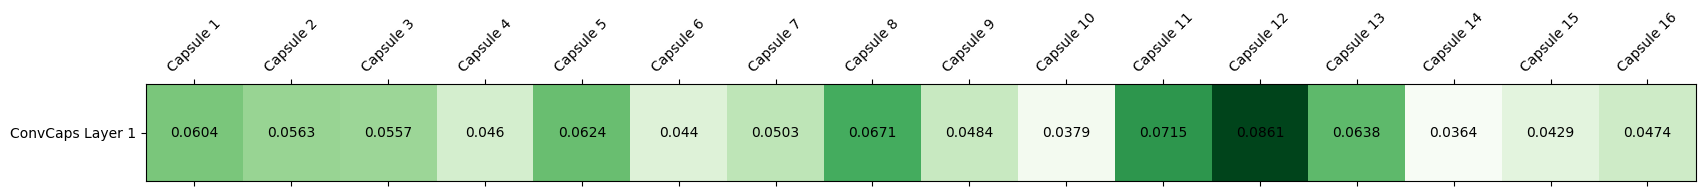

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter1_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter1_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

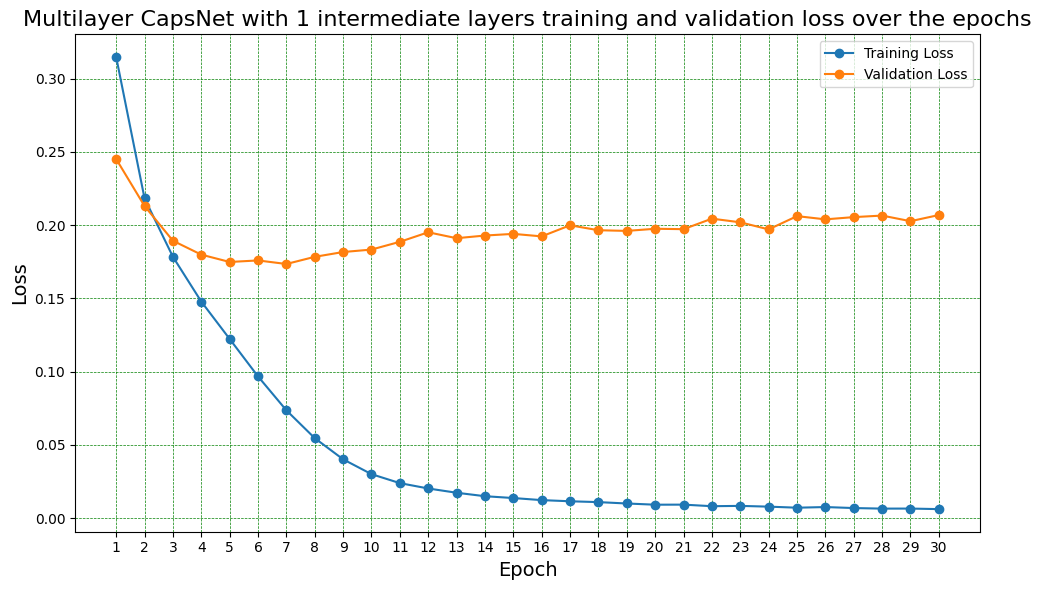

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer CapsNet with 1 intermediate layers training and validation loss over the epochs')

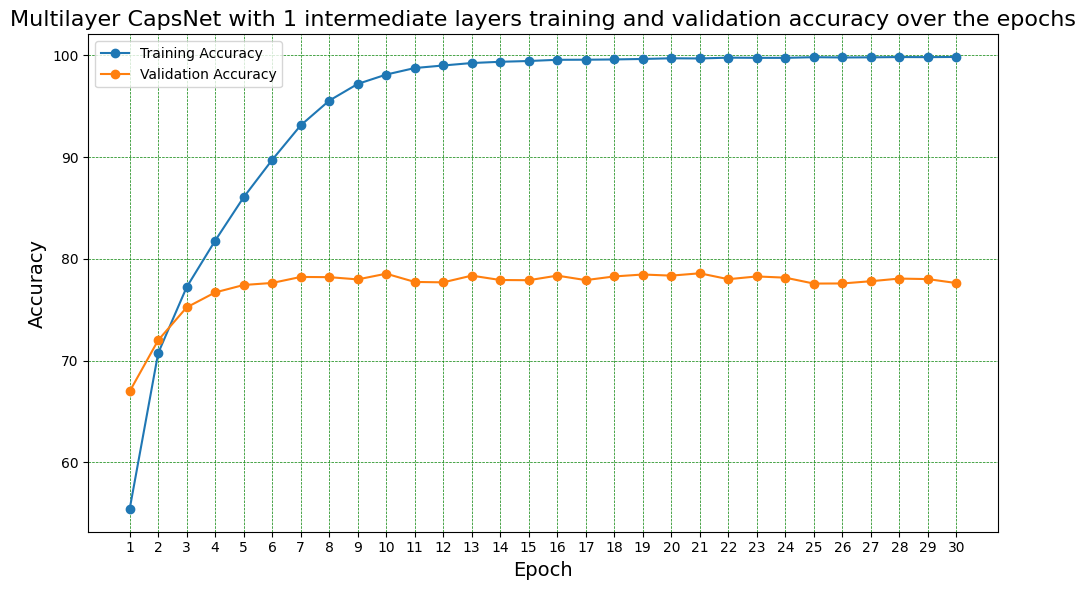

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer CapsNet with 1 intermediate layers training and validation accuracy over the epochs')

## 2 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"

batch_size=32

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
multilayer_inter2_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=10,
                                                              prim_caps_channels=16, prim_caps_dim=12, n_caps_layers=2)

multilayer_inter2_capsnet_cifar10_model.name = 'multilayer_inter2_capsnet_cifar10_model'
multilayer_inter2_capsnet_cifar10_model = multilayer_inter2_capsnet_cifar10_model.to(device)
multilayer_inter2_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAgg

In [ ]:
%%time
n_epochs = 30

criterion = caps.CapsNetLoss(n_class=10)

best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
                                                                multilayer_inter2_capsnet_cifar10_model,
                                                                criterion,
                                                                train_loader,
                                                                test_loader,
                                                                CIFAR10_TRAIN_DIR,
                                                                logger,
                                                                device=device)

01/22 08:41:01 PM | multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7425, Top 1 Acc=9.38, Top 5 Acc=68.75
INFO:capsnet:multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7425, Top 1 Acc=9.38, Top 5 Acc=68.75
01/22 08:41:12 PM | multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.5355, Top 1 Acc=20.55, Top 5 Acc=68.28
INFO:capsnet:multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.5355, Top 1 Acc=20.55, Top 5 Acc=68.28
01/22 08:41:22 PM | multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.4919, Top 1 Acc=25.24, Top 5 Acc=75.24
INFO:capsnet:multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.4919, Top 1 Acc=25.24, Top 5 Acc=75.24
01/22 08:41:33 PM | multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0.4687, Top 1 Acc=28.93, Top 5 Acc=79

KeyboardInterrupt: 

In [ ]:
%%time
n_epochs = 15
batch_size = 32
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=10)

checkpoint_file = CIFAR10_TRAIN_DIR+'Trained_multilayer_inter2_capsnet_cifar10_model_Epoch15_of_30.pt'

best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
                                                                multilayer_inter2_capsnet_cifar10_model,
                                                                criterion,
                                                                train_loader,
                                                                test_loader,
                                                                CIFAR10_TRAIN_DIR,
                                                                logger,
                                                                device=device,
                                                                checkpoint_file=checkpoint_file)

Files already downloaded and verified
Files already downloaded and verified


01/22 11:16:30 PM | multilayer_inter2_capsnet_cifar10_model best accuracy=78.550 saved at: /content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/code_repository/results/train/cifar10/Trained_multilayer_inter2_capsnet_cifar10_model_Epoch11_of_30.pt
INFO:capsnet:multilayer_inter2_capsnet_cifar10_model best accuracy=78.550 saved at: /content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/code_repository/results/train/cifar10/Trained_multilayer_inter2_capsnet_cifar10_model_Epoch11_of_30.pt


CPU times: user 1.38 s, sys: 290 ms, total: 1.67 s
Wall time: 4.82 s


### Export ConvCaps Activation

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"
batch_size=32
n_epochs=15
n_class=10

n_caps_layers=2
prim_caps_channels=16
prim_caps_dim=12

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
trained_multilayer_inter2_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter2_capsnet_cifar10_model.pt')

best_multilayer_inter2_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                   model_conv_config=model_conv_config,
                                                                   prim_caps_channels=prim_caps_channels,
                                                                   prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter2_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter2_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter2_capsnet_cifar10_model.name = 'best_multilayer_inter2_capsnet_cifar10_model'
best_multilayer_inter2_capsnet_cifar10_model = best_multilayer_inter2_capsnet_cifar10_model.to(device)
best_multilayer_inter2_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
  )
  (class_caps): CapsLayer()
)

In [ ]:
capsnet_inter2_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter2_capsnet_cifar10_model,
                                                                         test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/19 08:53:33 PM | best_multilayer_inter2_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=78.125, Top 5 Acc=100.000
INFO:capsnet:best_multilayer_inter2_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=78.125, Top 5 Acc=100.000
02/19 08:53:33 PM | best_multilayer_inter2_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=67.188, Top 5 Acc=96.875
INFO:capsnet:best_multilayer_inter2_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=67.188, Top 5 Acc=96.875
02/19 08:53:33 PM | best_multilayer_inter2_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=70.833, Top 5 Acc=97.917
INFO:capsnet:best_multilayer_inter2_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=70.833, Top 5 Acc=97.917
02/19 08:53:33 PM | best_multilayer_inter2_capsnet_cifar10_model - Iterations=4/313, Batch Size=32, Top 1 Acc=71.875, Top 5 Acc=98.438
INFO:capsnet:best_multilayer_inter2_capsnet_cifar10_model - Iterations=4/3

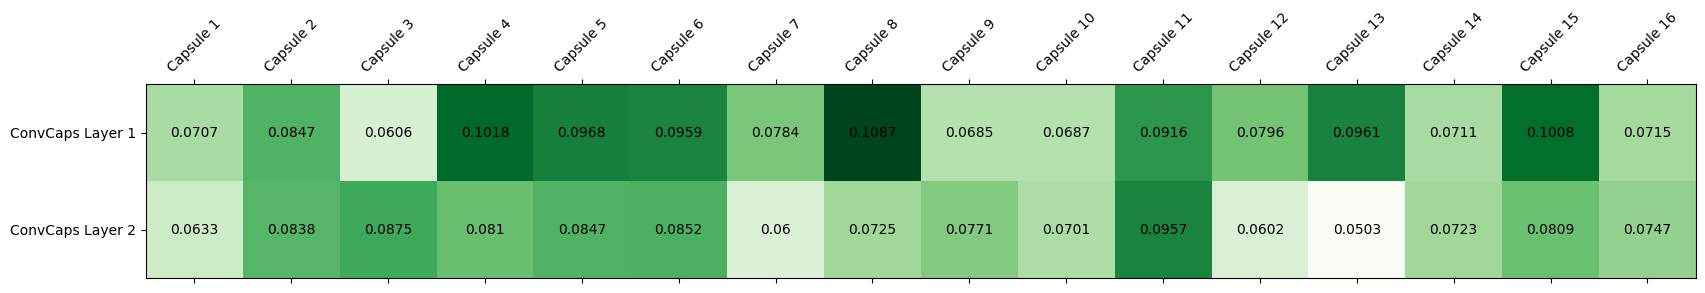

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter2_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter2_capsnet_cifar10_model_Epoch15_of_30.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

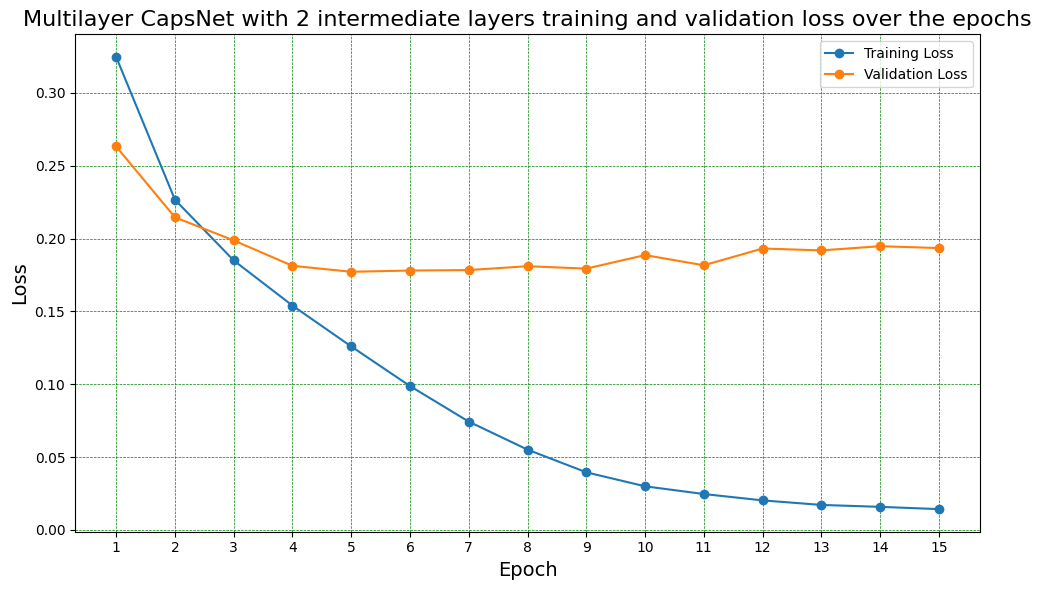

In [ ]:
utils.plot_line_chart(epoch_loss[:, :15], ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer CapsNet with 2 intermediate layers training and validation loss over the epochs')

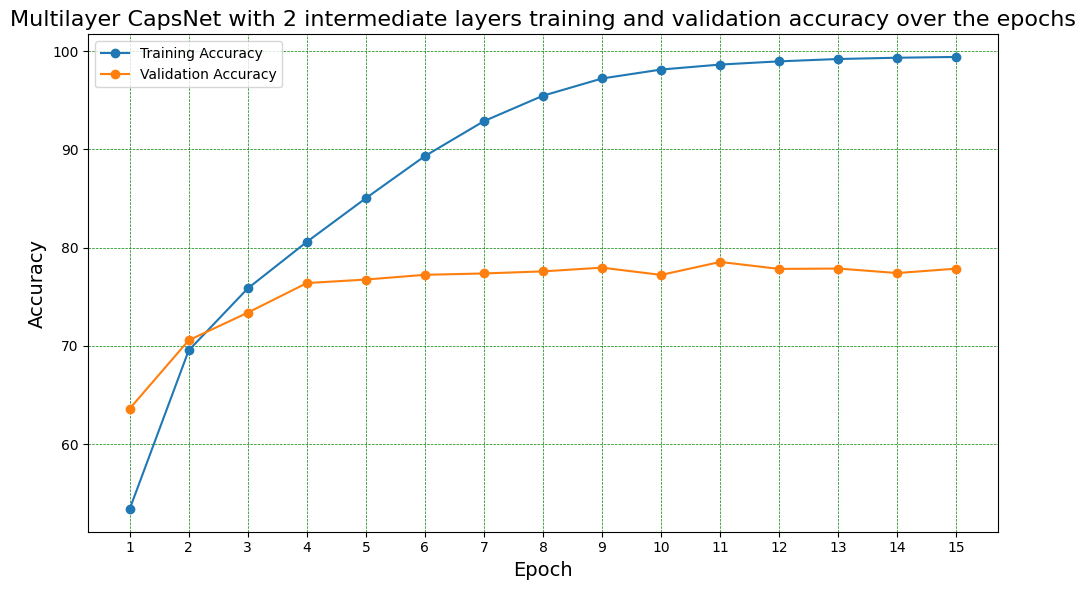

In [ ]:
utils.plot_line_chart(epoch_accuracy[:, :15], ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer CapsNet with 2 intermediate layers training and validation accuracy over the epochs')

## 3 Intermediate Layered CapsNet

In [ ]:
multilayer_inter3_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=10,
                                                              prim_caps_channels=16, prim_caps_dim=12, n_caps_layers=3)

multilayer_inter3_capsnet_cifar10_model.name = 'multilayer_inter3_capsnet_cifar10_model'
multilayer_inter3_capsnet_cifar10_model = multilayer_inter3_capsnet_cifar10_model.to(device)
multilayer_inter3_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
  )
 

In [ ]:
%%time
n_epochs = 15
batch_size = 32
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=10)

best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
                                                                multilayer_inter3_capsnet_cifar10_model,
                                                                criterion,
                                                                train_loader,
                                                                test_loader,
                                                                CIFAR10_TRAIN_DIR,
                                                                logger,
                                                                device=device)

Files already downloaded and verified
Files already downloaded and verified


01/22 11:20:18 PM | multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7423, Top 1 Acc=18.75, Top 5 Acc=59.38
INFO:capsnet:multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7423, Top 1 Acc=18.75, Top 5 Acc=59.38
01/22 11:20:33 PM | multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.5418, Top 1 Acc=23.01, Top 5 Acc=68.94
INFO:capsnet:multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.5418, Top 1 Acc=23.01, Top 5 Acc=68.94
01/22 11:20:50 PM | multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.4933, Top 1 Acc=28.51, Top 5 Acc=75.10
INFO:capsnet:multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.4933, Top 1 Acc=28.51, Top 5 Acc=75.10
01/22 11:21:06 PM | multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0.4696, Top 1 Acc=31.60, Top 5 Acc=

CPU times: user 3h 15min 59s, sys: 5min 9s, total: 3h 21min 8s
Wall time: 3h 22min 51s


### Export ConvCaps Activation

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"
batch_size=32
n_epochs=15
n_class=10

n_caps_layers=3
prim_caps_channels=16
prim_caps_dim=12

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
trained_multilayer_inter3_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter3_capsnet_cifar10_model.pt')

best_multilayer_inter3_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                   model_conv_config=model_conv_config,
                                                                   prim_caps_channels=prim_caps_channels,
                                                                   prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter3_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter3_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter3_capsnet_cifar10_model.name = 'best_multilayer_inter3_capsnet_cifar10_model'
best_multilayer_inter3_capsnet_cifar10_model = best_multilayer_inter3_capsnet_cifar10_model.to(device)
best_multilayer_inter3_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
  )
  (class_caps): 

In [ ]:
capsnet_inter3_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter3_capsnet_cifar10_model,
                                                                         test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/19 08:50:58 PM | best_multilayer_inter3_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=84.375, Top 5 Acc=100.000
INFO:capsnet:best_multilayer_inter3_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=84.375, Top 5 Acc=100.000
02/19 08:50:58 PM | best_multilayer_inter3_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=76.562, Top 5 Acc=96.875
INFO:capsnet:best_multilayer_inter3_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=76.562, Top 5 Acc=96.875
02/19 08:50:58 PM | best_multilayer_inter3_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=77.083, Top 5 Acc=97.917
INFO:capsnet:best_multilayer_inter3_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=77.083, Top 5 Acc=97.917
02/19 08:50:58 PM | best_multilayer_inter3_capsnet_cifar10_model - Iterations=4/313, Batch Size=32, Top 1 Acc=75.781, Top 5 Acc=98.438
INFO:capsnet:best_multilayer_inter3_capsnet_cifar10_model - Iterations=4/3

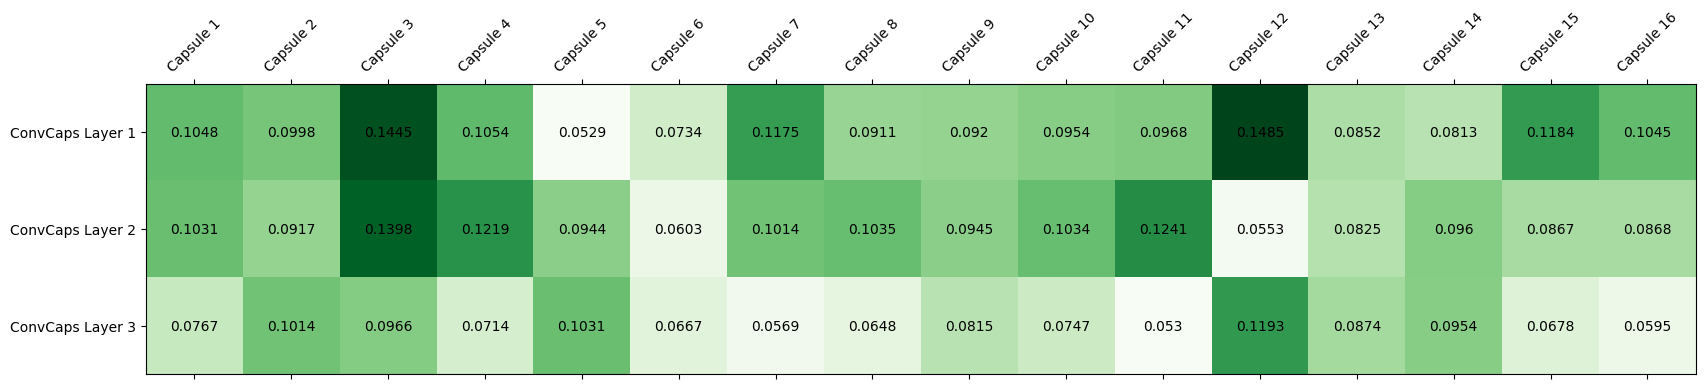

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter3_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter3_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

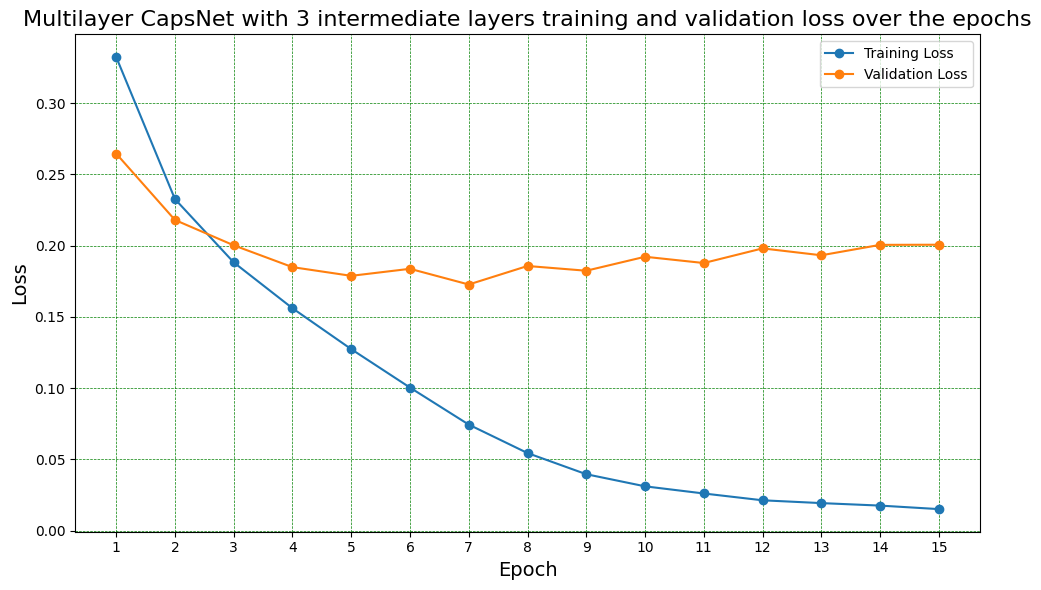

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer CapsNet with 3 intermediate layers training and validation loss over the epochs')

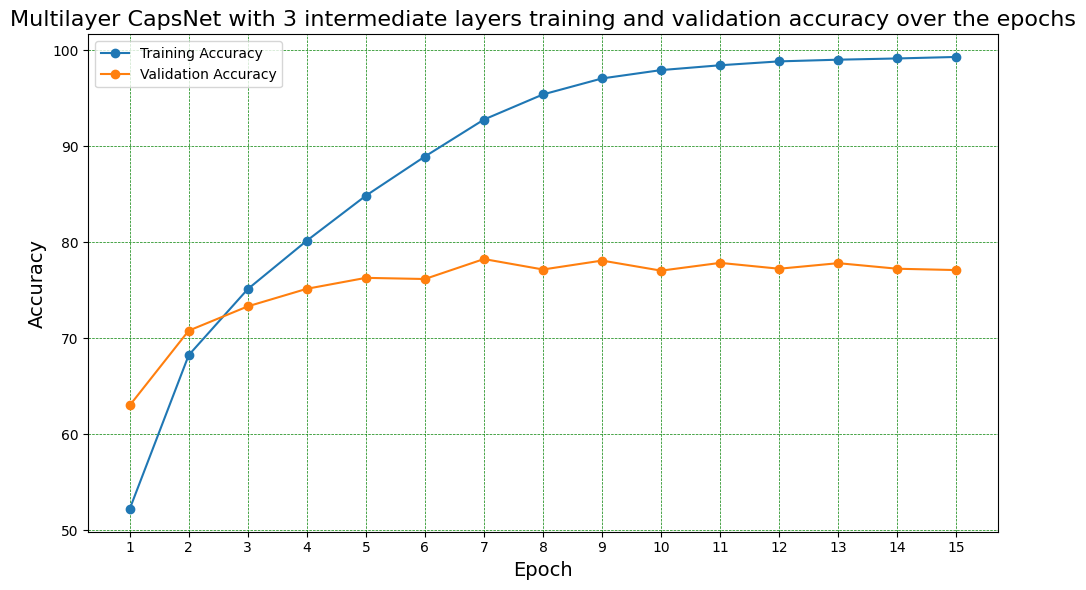

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer CapsNet with 3 intermediate layers training and validation accuracy over the epochs')

## 4 Intermediate Layered CapsNet

In [ ]:
multilayer_inter4_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=10,
                                                              prim_caps_channels=16, prim_caps_dim=12, n_caps_layers=4)

multilayer_inter4_capsnet_cifar10_model.name = 'multilayer_inter4_capsnet_cifar10_model'
multilayer_inter4_capsnet_cifar10_model = multilayer_inter4_capsnet_cifar10_model.to(device)
multilayer_inter4_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (

In [ ]:
%%time
n_epochs = 15
batch_size = 32
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=10)

best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
                                                                multilayer_inter4_capsnet_cifar10_model,
                                                                criterion,
                                                                train_loader,
                                                                test_loader,
                                                                CIFAR10_TRAIN_DIR,
                                                                logger,
                                                                device=device)

Files already downloaded and verified
Files already downloaded and verified


01/23 04:23:31 AM | multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7416, Top 1 Acc=12.50, Top 5 Acc=65.62
INFO:capsnet:multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7416, Top 1 Acc=12.50, Top 5 Acc=65.62
01/23 04:23:40 AM | multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.5699, Top 1 Acc=17.99, Top 5 Acc=63.07
INFO:capsnet:multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.5699, Top 1 Acc=17.99, Top 5 Acc=63.07
01/23 04:23:49 AM | multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5185, Top 1 Acc=22.60, Top 5 Acc=71.11
INFO:capsnet:multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5185, Top 1 Acc=22.60, Top 5 Acc=71.11
01/23 04:23:59 AM | multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0.4934, Top 1 Acc=25.58, Top 5 Acc=

CPU times: user 1h 49min 1s, sys: 6min 3s, total: 1h 55min 4s
Wall time: 1h 56min 9s


### Export ConvCaps Activation

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"
batch_size=32
n_epochs=15
n_class=10

n_caps_layers=4
prim_caps_channels=16
prim_caps_dim=12

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
trained_multilayer_inter4_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter4_capsnet_cifar10_model.pt')

best_multilayer_inter4_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                   model_conv_config=model_conv_config,
                                                                   prim_caps_channels=prim_caps_channels,
                                                                   prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter4_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter4_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter4_capsnet_cifar10_model.name = 'best_multilayer_inter4_capsnet_cifar10_model'
best_multilayer_inter4_capsnet_cifar10_model = best_multilayer_inter4_capsnet_cifar10_model.to(device)
best_multilayer_inter4_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
capsnet_inter4_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter4_capsnet_cifar10_model,
                                                                         test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/19 08:48:11 PM | best_multilayer_inter4_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=78.125, Top 5 Acc=96.875
INFO:capsnet:best_multilayer_inter4_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=78.125, Top 5 Acc=96.875
02/19 08:48:11 PM | best_multilayer_inter4_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=71.875, Top 5 Acc=96.875
INFO:capsnet:best_multilayer_inter4_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=71.875, Top 5 Acc=96.875
02/19 08:48:12 PM | best_multilayer_inter4_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=71.875, Top 5 Acc=97.917
INFO:capsnet:best_multilayer_inter4_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=71.875, Top 5 Acc=97.917
02/19 08:48:12 PM | best_multilayer_inter4_capsnet_cifar10_model - Iterations=4/313, Batch Size=32, Top 1 Acc=70.312, Top 5 Acc=98.438
INFO:capsnet:best_multilayer_inter4_capsnet_cifar10_model - Iterations=4/313

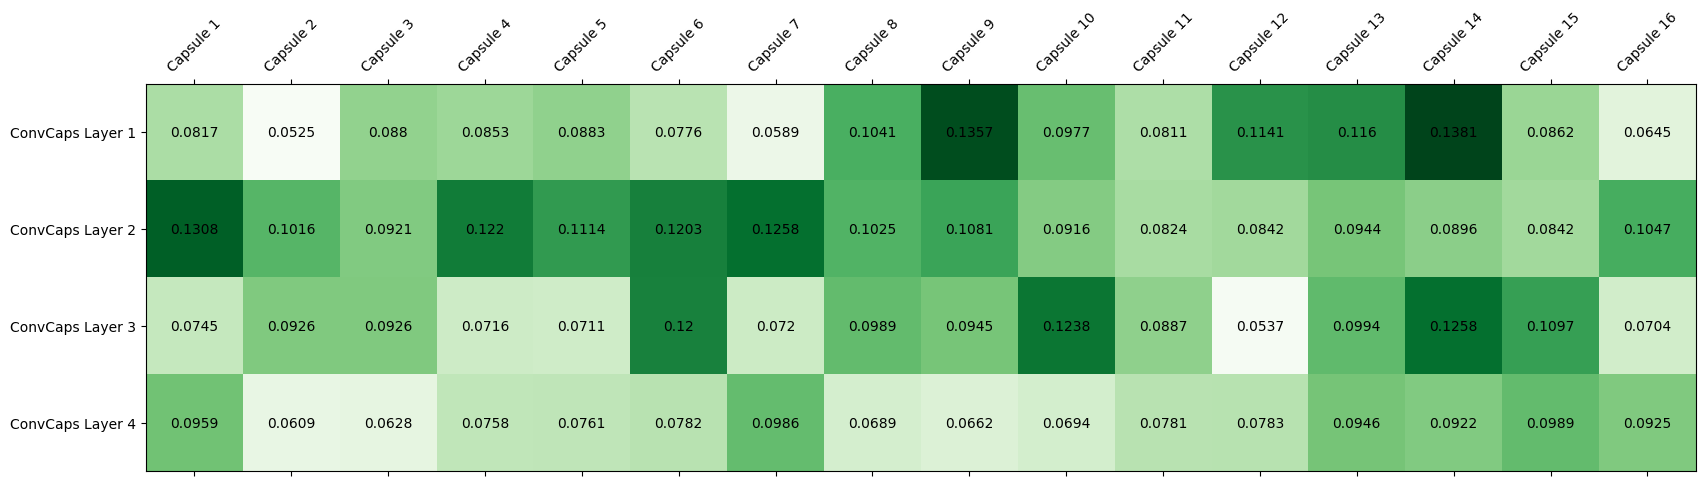

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter4_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter4_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

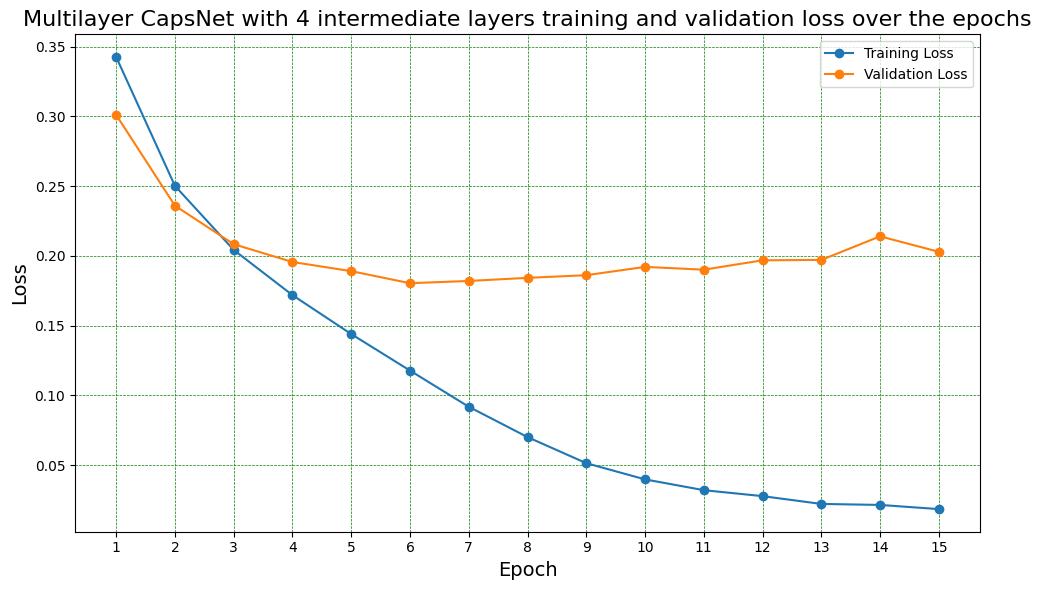

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer CapsNet with 4 intermediate layers training and validation loss over the epochs')

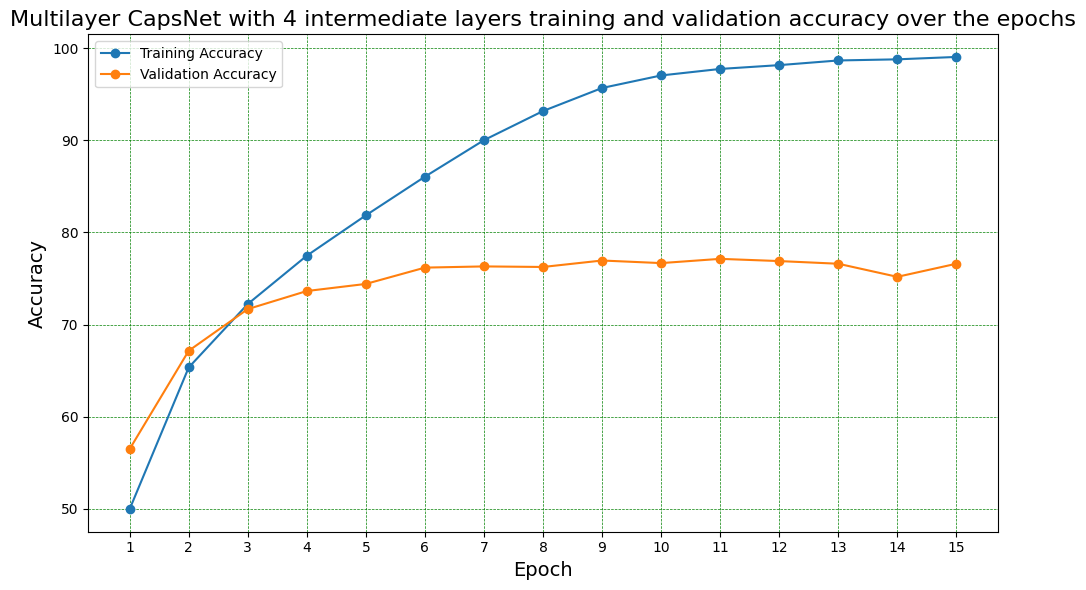

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer CapsNet with 4 intermediate layers training and validation accuracy over the epochs')

## 5 Intermediate Layered CapsNet

In [ ]:
multilayer_inter5_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=10,
                                                              prim_caps_channels=16, prim_caps_dim=12, n_caps_layers=5)

multilayer_inter5_capsnet_cifar10_model.name = 'multilayer_inter5_capsnet_cifar10_model'
multilayer_inter5_capsnet_cifar10_model = multilayer_inter5_capsnet_cifar10_model.to(device)
multilayer_inter5_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (

In [ ]:
%%time
n_epochs = 30
batch_size = 32
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=10)

best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
                                                                multilayer_inter5_capsnet_cifar10_model,
                                                                criterion,
                                                                train_loader,
                                                                test_loader,
                                                                CIFAR10_TRAIN_DIR,
                                                                logger,
                                                                device=device)

Files already downloaded and verified
Files already downloaded and verified


01/22 02:22:48 PM | multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7490, Top 1 Acc=6.25, Top 5 Acc=43.75
INFO:capsnet:multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7490, Top 1 Acc=6.25, Top 5 Acc=43.75
01/22 02:22:56 PM | multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.5824, Top 1 Acc=16.76, Top 5 Acc=60.04
INFO:capsnet:multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.5824, Top 1 Acc=16.76, Top 5 Acc=60.04
01/22 02:23:05 PM | multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5325, Top 1 Acc=21.73, Top 5 Acc=66.83
INFO:capsnet:multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5325, Top 1 Acc=21.73, Top 5 Acc=66.83
01/22 02:23:14 PM | multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0.5044, Top 1 Acc=25.84, Top 5 Acc=71

CPU times: user 3h 27min, sys: 12min 32s, total: 3h 39min 32s
Wall time: 3h 38min 58s


### Export ConvCaps Activation

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"
batch_size=32
n_epochs=15
n_class=10

n_caps_layers=5
prim_caps_channels=16
prim_caps_dim=12

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
trained_multilayer_inter5_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter5_capsnet_cifar10_model.pt')

best_multilayer_inter5_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                   model_conv_config=model_conv_config,
                                                                   prim_caps_channels=prim_caps_channels,
                                                                   prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter5_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter5_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter5_capsnet_cifar10_model.name = 'best_multilayer_inter5_capsnet_cifar10_model'
best_multilayer_inter5_capsnet_cifar10_model = best_multilayer_inter5_capsnet_cifar10_model.to(device)
best_multilayer_inter5_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
capsnet_inter5_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter5_capsnet_cifar10_model,
                                                                         test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/19 08:45:09 PM | best_multilayer_inter5_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=81.250, Top 5 Acc=100.000
INFO:capsnet:best_multilayer_inter5_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=81.250, Top 5 Acc=100.000
02/19 08:45:09 PM | best_multilayer_inter5_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=71.875, Top 5 Acc=96.875
INFO:capsnet:best_multilayer_inter5_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=71.875, Top 5 Acc=96.875
02/19 08:45:09 PM | best_multilayer_inter5_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=73.958, Top 5 Acc=97.917
INFO:capsnet:best_multilayer_inter5_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=73.958, Top 5 Acc=97.917
02/19 08:45:10 PM | best_multilayer_inter5_capsnet_cifar10_model - Iterations=4/313, Batch Size=32, Top 1 Acc=74.219, Top 5 Acc=98.438
INFO:capsnet:best_multilayer_inter5_capsnet_cifar10_model - Iterations=4/3

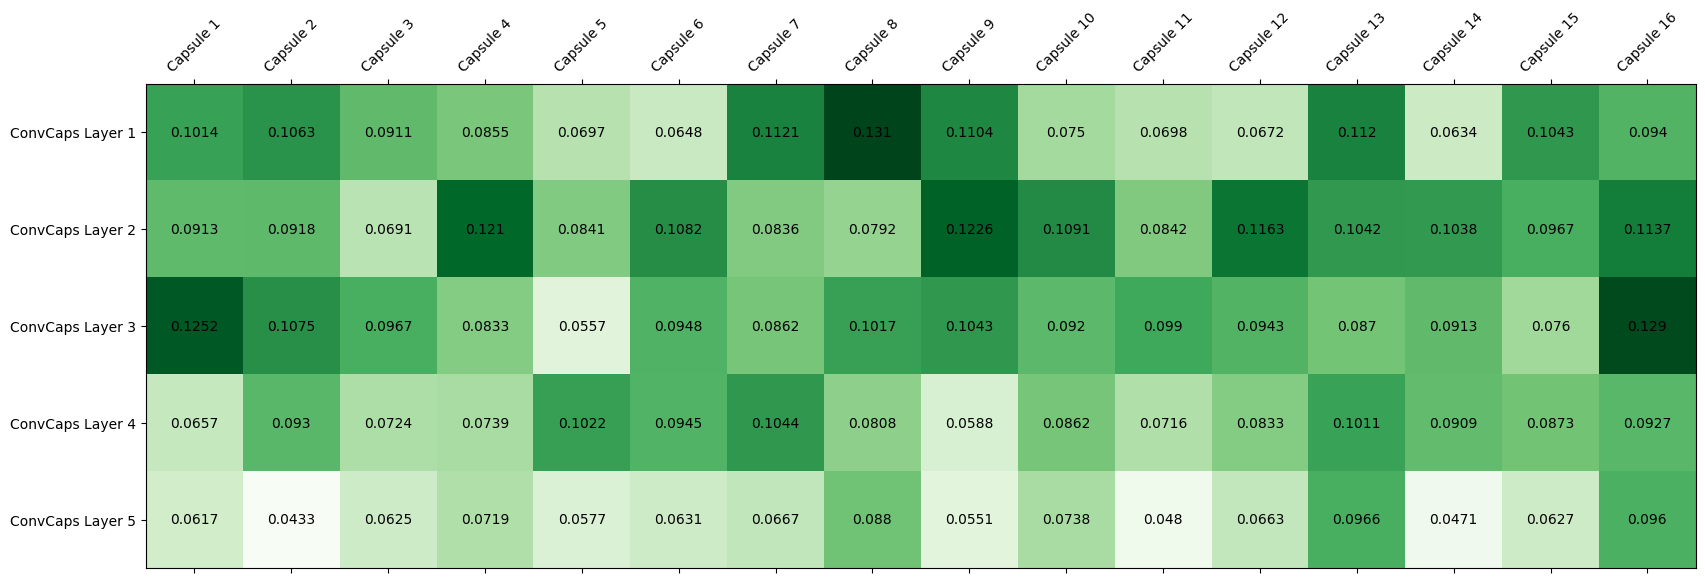

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter5_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter5_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

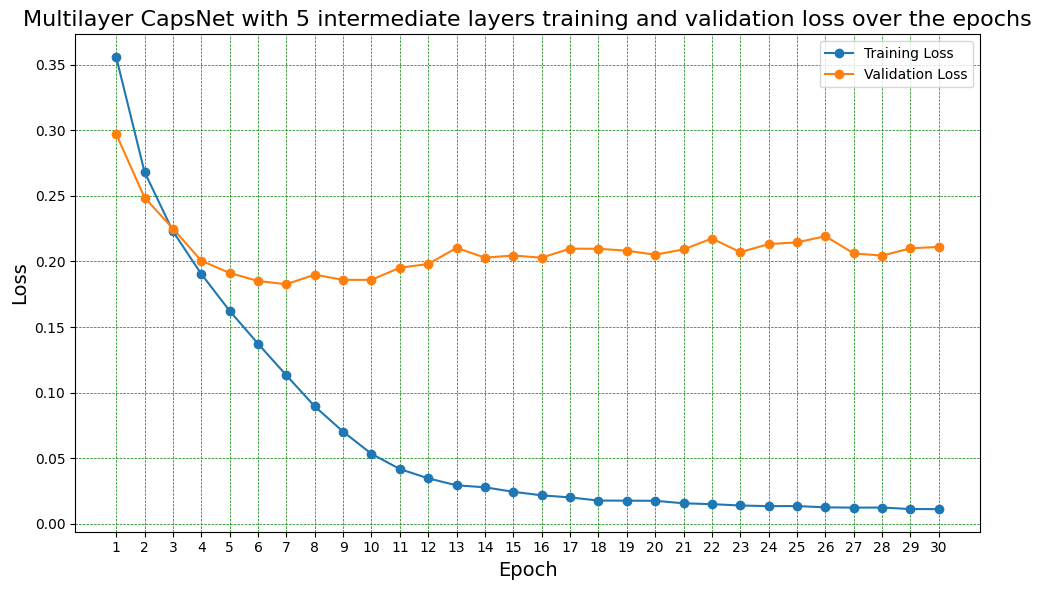

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      ' Multilayer (5 intermediate layers) CapsNet training and validation loss over the epochs')

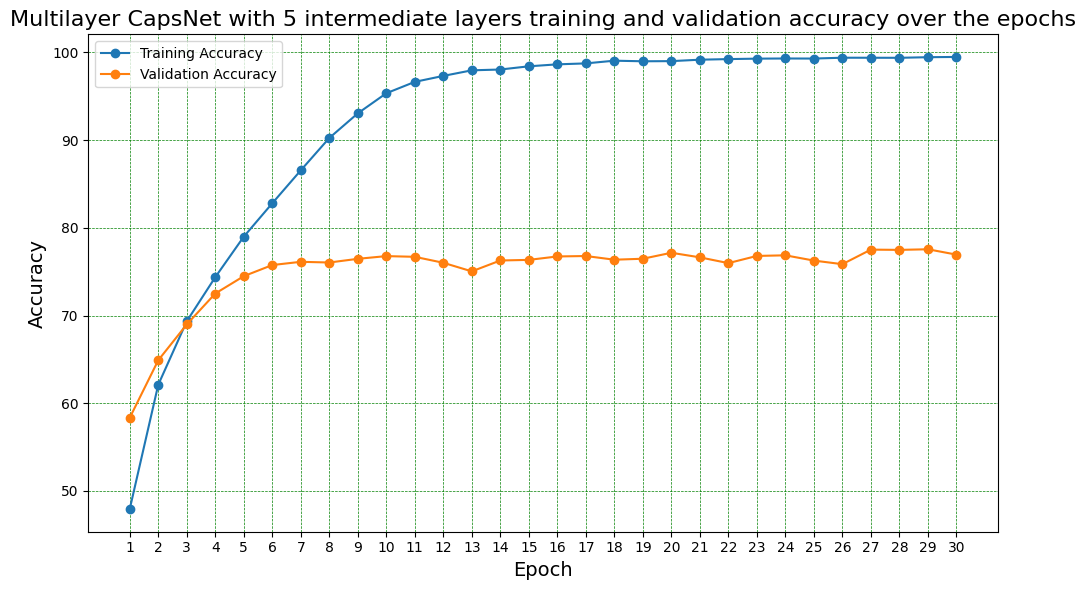

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer CapsNet with 5 intermediate layers training and validation accuracy over the epochs')

## 6 Intermediate Layered CapsNet

In [ ]:
multilayer_inter6_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=10,
                                                              prim_caps_channels=16, prim_caps_dim=12, n_caps_layers=6)

multilayer_inter6_capsnet_cifar10_model.name = 'multilayer_inter6_capsnet_cifar10_model'
multilayer_inter6_capsnet_cifar10_model = multilayer_inter6_capsnet_cifar10_model.to(device)
multilayer_inter6_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (

In [ ]:
%%time
n_epochs = 15
batch_size = 32
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=10)

best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
                                                                multilayer_inter6_capsnet_cifar10_model,
                                                                criterion,
                                                                train_loader,
                                                                test_loader,
                                                                CIFAR10_TRAIN_DIR,
                                                                logger,
                                                                device=device)

100%|██████████| 170498071/170498071 [00:01<00:00, 104748639.29it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


01/23 12:57:33 PM | multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7453, Top 1 Acc=9.38, Top 5 Acc=62.50
INFO:capsnet:multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7453, Top 1 Acc=9.38, Top 5 Acc=62.50
01/23 12:57:43 PM | multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6166, Top 1 Acc=12.41, Top 5 Acc=58.24
INFO:capsnet:multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6166, Top 1 Acc=12.41, Top 5 Acc=58.24
01/23 12:57:53 PM | multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5512, Top 1 Acc=17.69, Top 5 Acc=67.21
INFO:capsnet:multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5512, Top 1 Acc=17.69, Top 5 Acc=67.21
01/23 12:58:02 PM | multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0.5201, Top 1 Acc=21.88, Top 5 Acc=71

CPU times: user 1h 58min 17s, sys: 6min 51s, total: 2h 5min 8s
Wall time: 2h 4min 53s


### Export ConvCaps Activation

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"
batch_size=32
n_epochs=15
n_class=10

n_caps_layers=6
prim_caps_channels=16
prim_caps_dim=12

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
trained_multilayer_inter6_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter6_capsnet_cifar10_model.pt')

best_multilayer_inter6_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                   model_conv_config=model_conv_config,
                                                                   prim_caps_channels=prim_caps_channels,
                                                                   prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter6_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter6_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter6_capsnet_cifar10_model.name = 'best_multilayer_inter6_capsnet_cifar10_model'
best_multilayer_inter6_capsnet_cifar10_model = best_multilayer_inter6_capsnet_cifar10_model.to(device)
best_multilayer_inter6_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
capsnet_inter6_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter6_capsnet_cifar10_model,
                                                                         test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/19 08:42:09 PM | best_multilayer_inter6_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=87.500, Top 5 Acc=100.000
INFO:capsnet:best_multilayer_inter6_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=87.500, Top 5 Acc=100.000
02/19 08:42:09 PM | best_multilayer_inter6_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=78.125, Top 5 Acc=95.312
INFO:capsnet:best_multilayer_inter6_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=78.125, Top 5 Acc=95.312
02/19 08:42:09 PM | best_multilayer_inter6_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=77.083, Top 5 Acc=94.792
INFO:capsnet:best_multilayer_inter6_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=77.083, Top 5 Acc=94.792
02/19 08:42:09 PM | best_multilayer_inter6_capsnet_cifar10_model - Iterations=4/313, Batch Size=32, Top 1 Acc=75.000, Top 5 Acc=95.312
INFO:capsnet:best_multilayer_inter6_capsnet_cifar10_model - Iterations=4/3

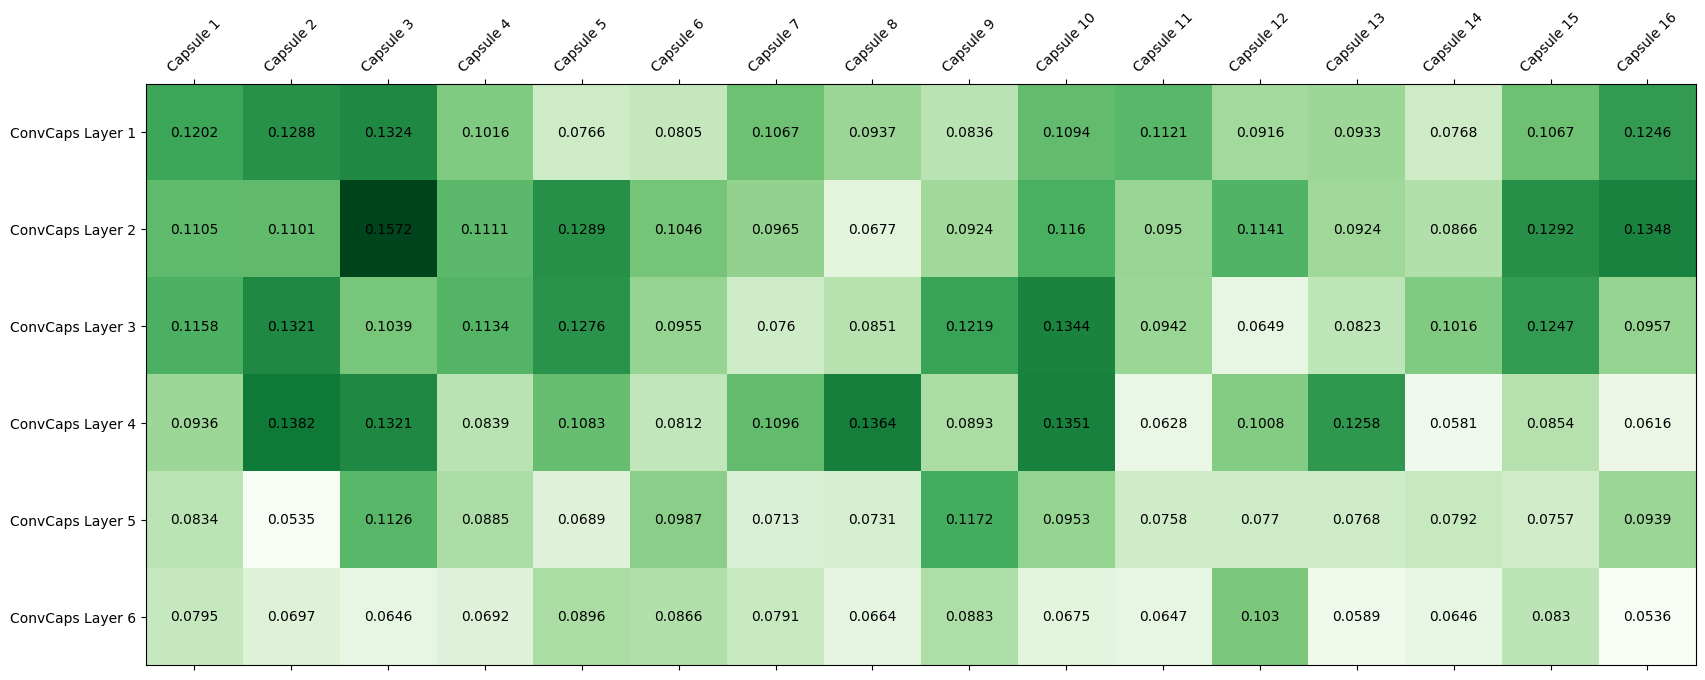

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter6_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter6_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

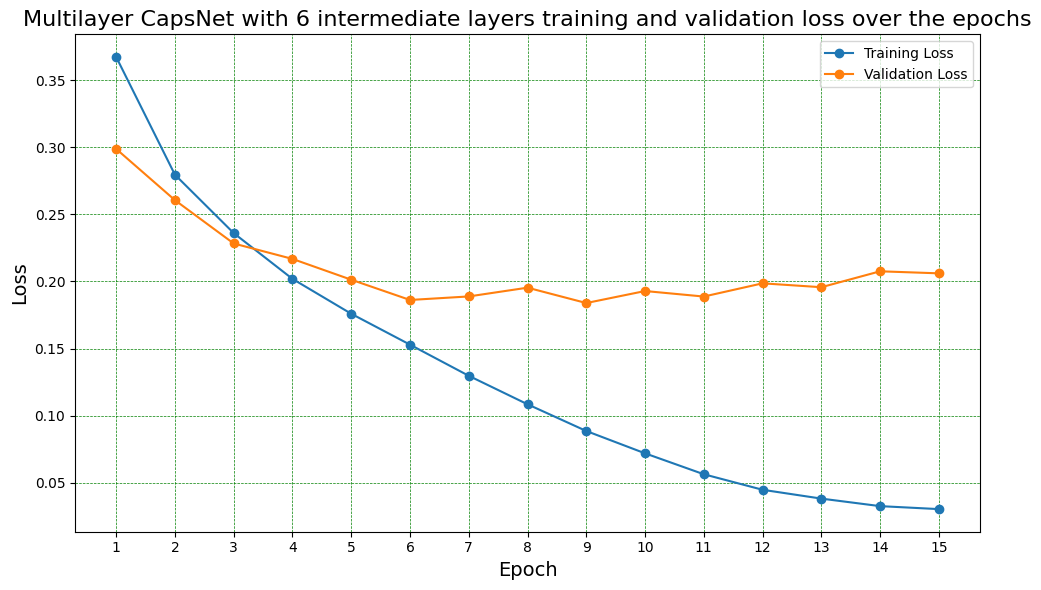

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer CapsNet with 6 intermediate layers training and validation loss over the epochs')

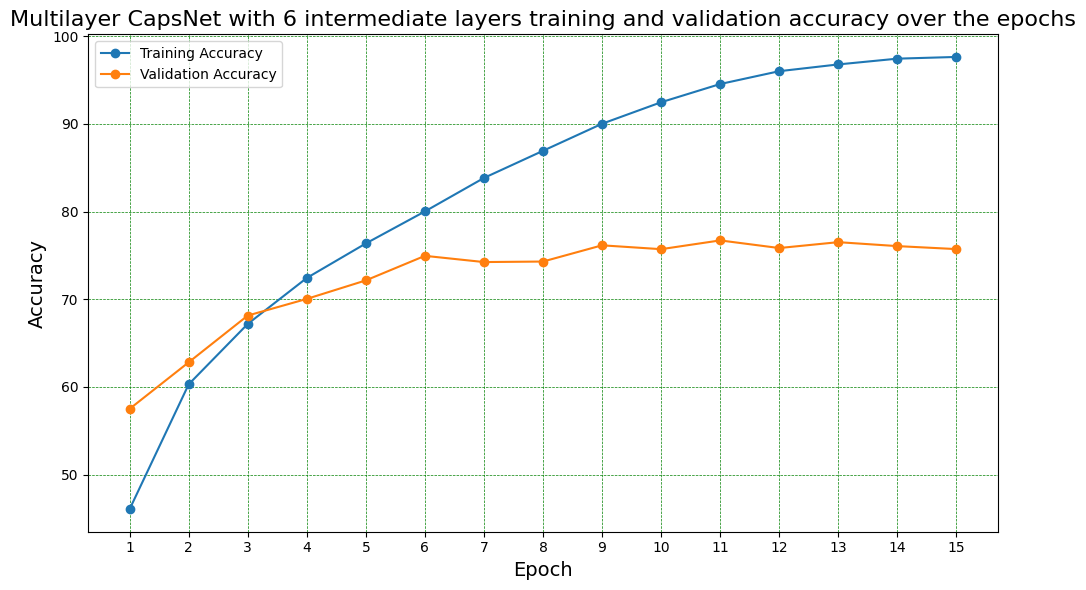

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer CapsNet with 6 intermediate layers training and validation accuracy over the epochs')

## 7 Intermediate Layered CapsNet

In [ ]:
multilayer_inter7_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=10,
                                                              prim_caps_channels=16, prim_caps_dim=12, n_caps_layers=7)

multilayer_inter7_capsnet_cifar10_model.name = 'multilayer_inter7_capsnet_cifar10_model'
multilayer_inter7_capsnet_cifar10_model = multilayer_inter7_capsnet_cifar10_model.to(device)
multilayer_inter7_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (

In [ ]:
%%time
n_epochs = 15
batch_size = 32
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=10)

best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
                                                                multilayer_inter7_capsnet_cifar10_model,
                                                                criterion,
                                                                train_loader,
                                                                test_loader,
                                                                CIFAR10_TRAIN_DIR,
                                                                logger,
                                                                device=device)

Files already downloaded and verified
Files already downloaded and verified


01/23 03:03:39 PM | multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7513, Top 1 Acc=9.38, Top 5 Acc=56.25
INFO:capsnet:multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7513, Top 1 Acc=9.38, Top 5 Acc=56.25
01/23 03:03:50 PM | multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6393, Top 1 Acc=13.35, Top 5 Acc=55.21
INFO:capsnet:multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6393, Top 1 Acc=13.35, Top 5 Acc=55.21
01/23 03:04:01 PM | multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5632, Top 1 Acc=18.89, Top 5 Acc=63.41
INFO:capsnet:multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5632, Top 1 Acc=18.89, Top 5 Acc=63.41
01/23 03:04:12 PM | multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0.5286, Top 1 Acc=22.07, Top 5 Acc=68

CPU times: user 2h 14min 45s, sys: 7min 44s, total: 2h 22min 29s
Wall time: 2h 22min 5s


### Export ConvCaps Activation

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"
batch_size=32
n_epochs=15
n_class=10

n_caps_layers=7
prim_caps_channels=16
prim_caps_dim=12

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
trained_multilayer_inter7_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter7_capsnet_cifar10_model.pt')

best_multilayer_inter7_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                   model_conv_config=model_conv_config,
                                                                   prim_caps_channels=prim_caps_channels,
                                                                   prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter7_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter7_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter7_capsnet_cifar10_model.name = 'best_multilayer_inter7_capsnet_cifar10_model'
best_multilayer_inter7_capsnet_cifar10_model = best_multilayer_inter7_capsnet_cifar10_model.to(device)
best_multilayer_inter7_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
capsnet_inter7_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter7_capsnet_cifar10_model,
                                                                         test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/19 08:37:24 PM | best_multilayer_inter7_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=87.500, Top 5 Acc=100.000
INFO:capsnet:best_multilayer_inter7_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=87.500, Top 5 Acc=100.000
02/19 08:37:24 PM | best_multilayer_inter7_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=75.000, Top 5 Acc=96.875
INFO:capsnet:best_multilayer_inter7_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=75.000, Top 5 Acc=96.875
02/19 08:37:25 PM | best_multilayer_inter7_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=70.833, Top 5 Acc=96.875
INFO:capsnet:best_multilayer_inter7_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=70.833, Top 5 Acc=96.875
02/19 08:37:25 PM | best_multilayer_inter7_capsnet_cifar10_model - Iterations=4/313, Batch Size=32, Top 1 Acc=69.531, Top 5 Acc=97.656
INFO:capsnet:best_multilayer_inter7_capsnet_cifar10_model - Iterations=4/3

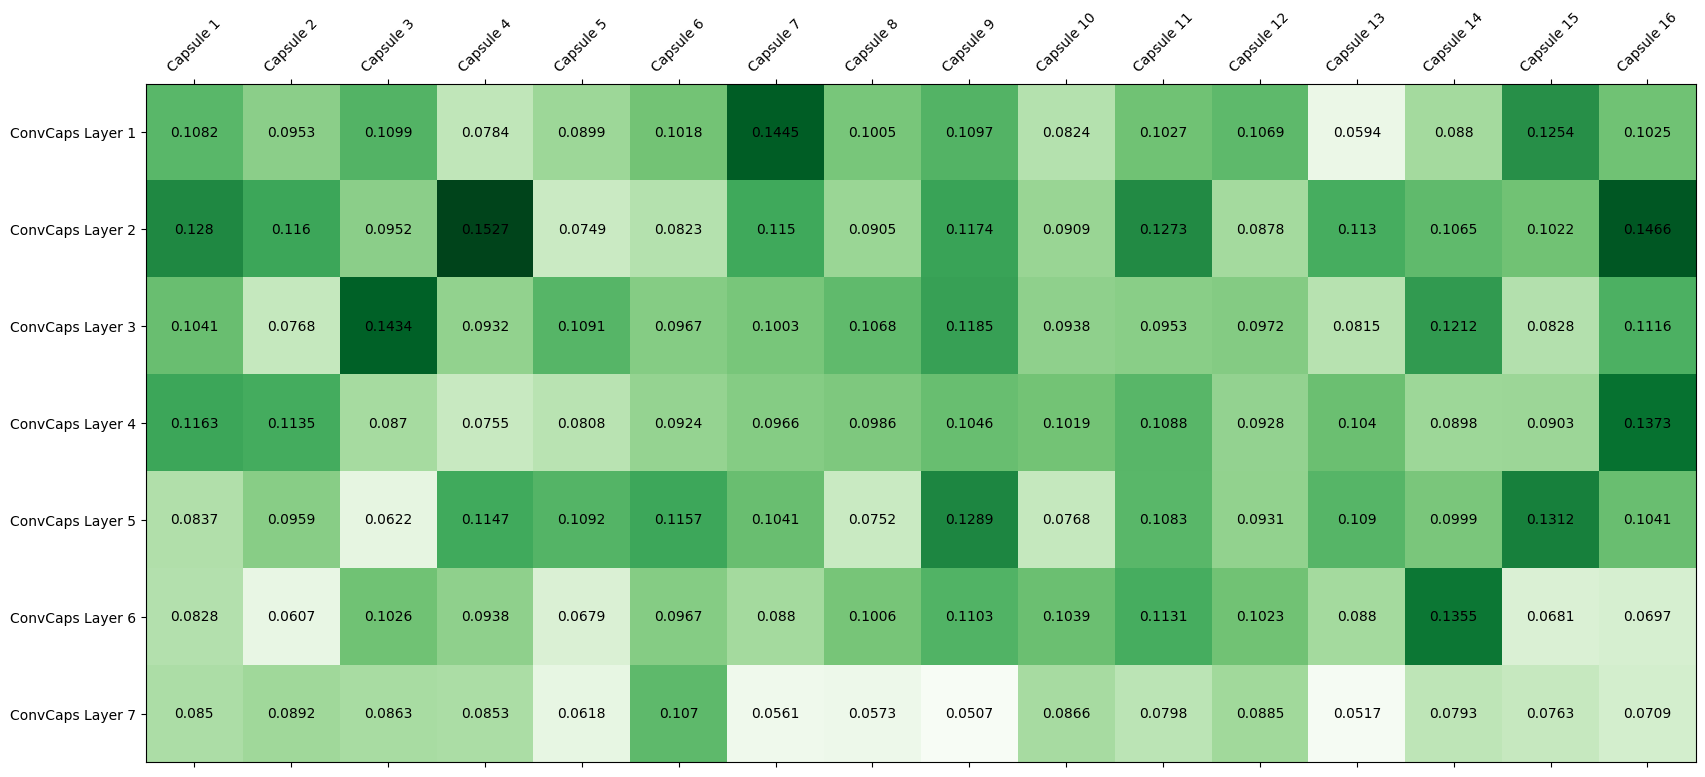

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter7_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter7_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

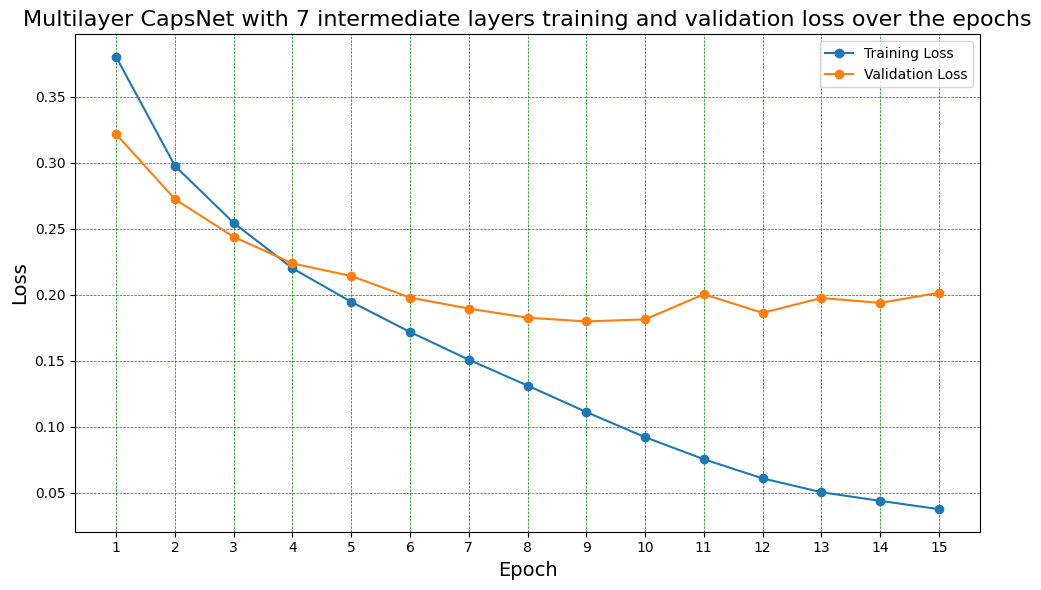

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer CapsNet with 7 intermediate layers training and validation loss over the epochs')

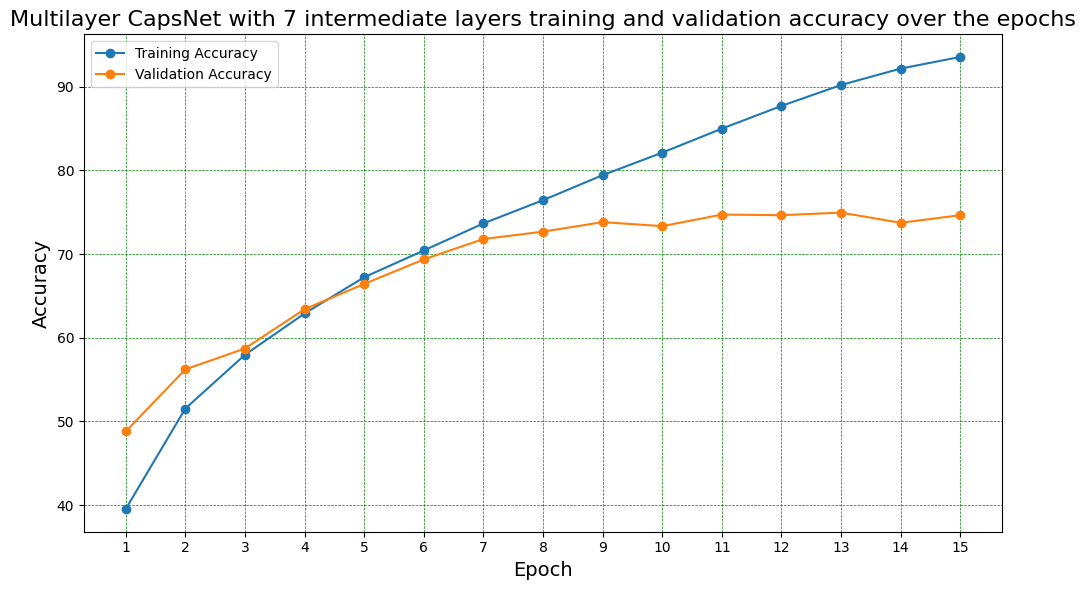

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer CapsNet with 7 intermediate layers training and validation accuracy over the epochs')

## 8 Intermediate Layered CapsNet

In [ ]:
multilayer_inter8_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=10,
                                                              prim_caps_channels=16, prim_caps_dim=12, n_caps_layers=8)

multilayer_inter8_capsnet_cifar10_model.name = 'multilayer_inter8_capsnet_cifar10_model'
multilayer_inter8_capsnet_cifar10_model = multilayer_inter8_capsnet_cifar10_model.to(device)
multilayer_inter8_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (

In [ ]:
%%time
n_epochs = 15
batch_size = 32
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=10)

best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
                                                                multilayer_inter8_capsnet_cifar10_model,
                                                                criterion,
                                                                train_loader,
                                                                test_loader,
                                                                CIFAR10_TRAIN_DIR,
                                                                logger,
                                                                device=device)

Files already downloaded and verified
Files already downloaded and verified


01/23 05:28:36 PM | multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7519, Top 1 Acc=0.00, Top 5 Acc=37.50
INFO:capsnet:multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7519, Top 1 Acc=0.00, Top 5 Acc=37.50
01/23 05:28:48 PM | multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6648, Top 1 Acc=10.61, Top 5 Acc=53.79
INFO:capsnet:multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6648, Top 1 Acc=10.61, Top 5 Acc=53.79
01/23 05:29:01 PM | multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5848, Top 1 Acc=15.67, Top 5 Acc=61.25
INFO:capsnet:multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5848, Top 1 Acc=15.67, Top 5 Acc=61.25
01/23 05:29:14 PM | multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0.5501, Top 1 Acc=18.49, Top 5 Acc=66

CPU times: user 2h 31min 43s, sys: 8min 38s, total: 2h 40min 21s
Wall time: 2h 39min 55s


### Export ConvCaps Activation

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"
batch_size=32
n_epochs=15
n_class=10

n_caps_layers=8
prim_caps_channels=16
prim_caps_dim=12

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
trained_multilayer_inter8_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter8_capsnet_cifar10_model.pt')

best_multilayer_inter8_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                   model_conv_config=model_conv_config,
                                                                   prim_caps_channels=prim_caps_channels,
                                                                   prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter8_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter8_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter8_capsnet_cifar10_model.name = 'best_multilayer_inter8_capsnet_cifar10_model'
best_multilayer_inter8_capsnet_cifar10_model = best_multilayer_inter8_capsnet_cifar10_model.to(device)
best_multilayer_inter8_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
capsnet_inter8_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter8_capsnet_cifar10_model,
                                                                         test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/19 08:27:17 PM | best_multilayer_inter8_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=90.625, Top 5 Acc=100.000
INFO:capsnet:best_multilayer_inter8_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=90.625, Top 5 Acc=100.000
02/19 08:27:17 PM | best_multilayer_inter8_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=76.562, Top 5 Acc=98.438
INFO:capsnet:best_multilayer_inter8_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=76.562, Top 5 Acc=98.438
02/19 08:27:18 PM | best_multilayer_inter8_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=73.958, Top 5 Acc=97.917
INFO:capsnet:best_multilayer_inter8_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=73.958, Top 5 Acc=97.917
02/19 08:27:18 PM | best_multilayer_inter8_capsnet_cifar10_model - Iterations=4/313, Batch Size=32, Top 1 Acc=76.562, Top 5 Acc=98.438
INFO:capsnet:best_multilayer_inter8_capsnet_cifar10_model - Iterations=4/3

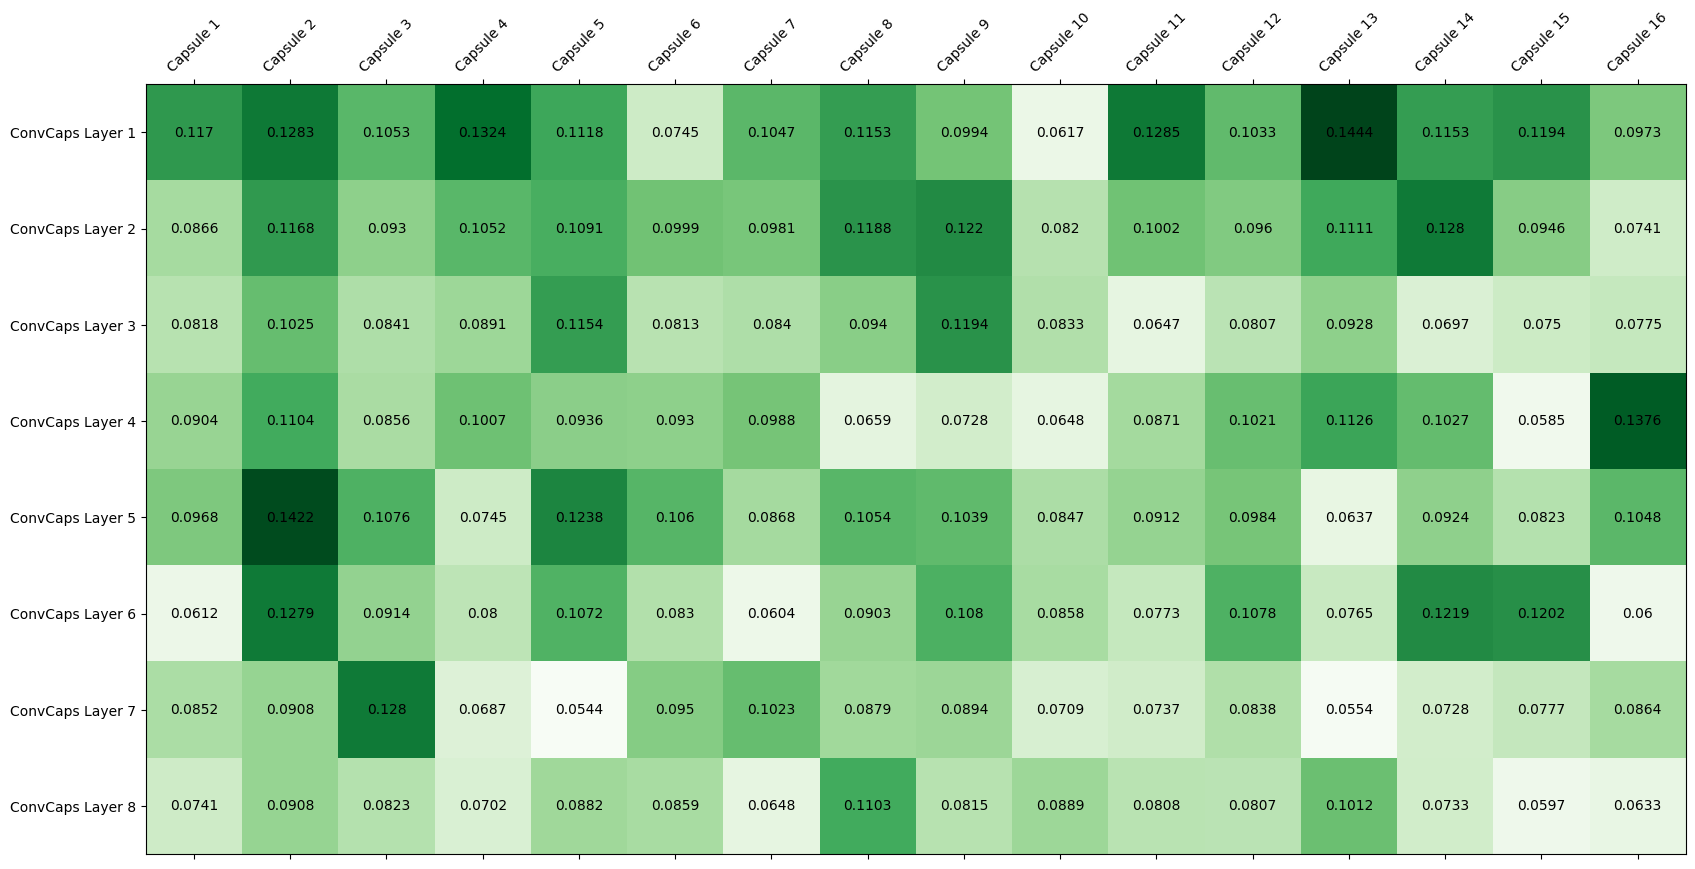

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter8_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter8_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

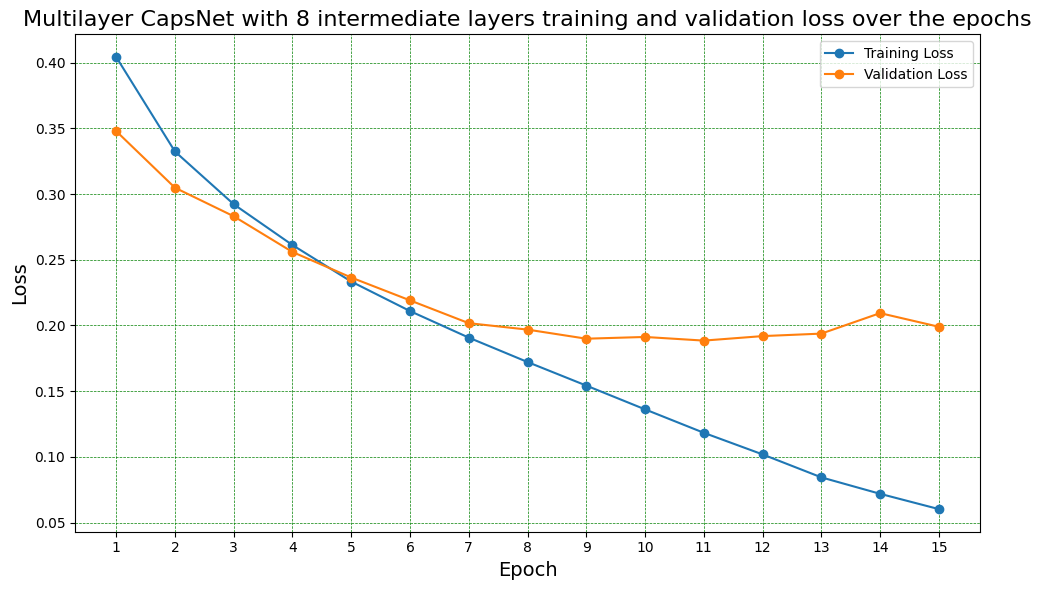

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer CapsNet with 8 intermediate layers training and validation loss over the epochs')

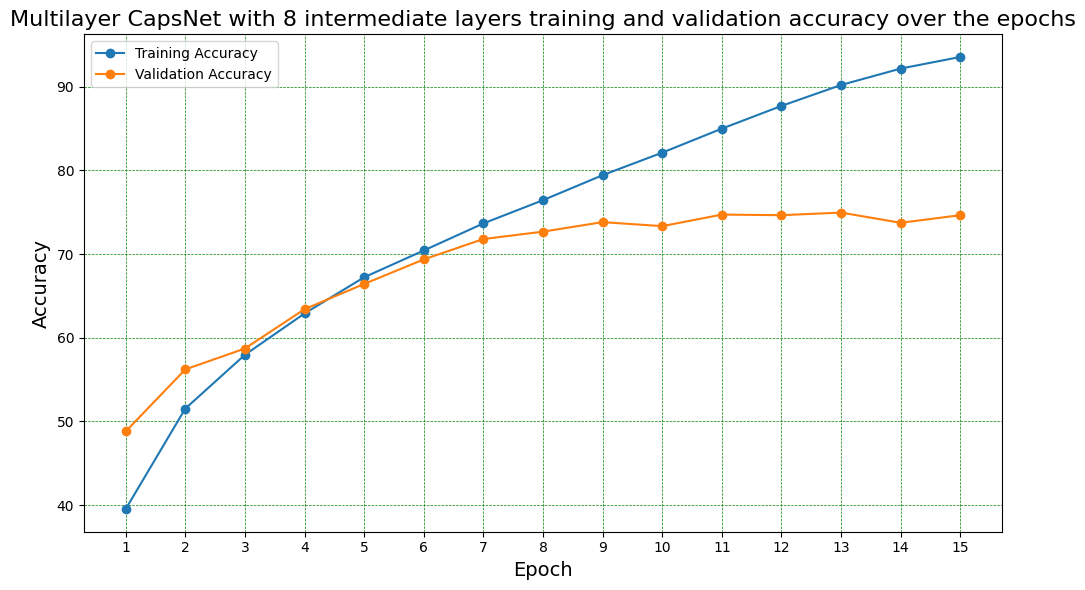

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer CapsNet with 8 intermediate layers training and validation accuracy over the epochs')

## 9 Intermediate Layered CapsNet

In [ ]:
multilayer_inter9_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=10,
                                                              prim_caps_channels=16, prim_caps_dim=12, n_caps_layers=9)

multilayer_inter9_capsnet_cifar10_model.name = 'multilayer_inter9_capsnet_cifar10_model'
multilayer_inter9_capsnet_cifar10_model = multilayer_inter9_capsnet_cifar10_model.to(device)
multilayer_inter9_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (

In [ ]:
%%time
n_epochs = 15
batch_size = 32
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=10)

best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
                                                                multilayer_inter9_capsnet_cifar10_model,
                                                                criterion,
                                                                train_loader,
                                                                test_loader,
                                                                CIFAR10_TRAIN_DIR,
                                                                logger,
                                                                device=device)

Files already downloaded and verified
Files already downloaded and verified


01/23 08:26:44 PM | multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7534, Top 1 Acc=12.50, Top 5 Acc=59.38
INFO:capsnet:multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7534, Top 1 Acc=12.50, Top 5 Acc=59.38
01/23 08:26:58 PM | multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.7019, Top 1 Acc=12.97, Top 5 Acc=53.31
INFO:capsnet:multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.7019, Top 1 Acc=12.97, Top 5 Acc=53.31
01/23 08:27:12 PM | multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.6138, Top 1 Acc=14.04, Top 5 Acc=56.68
INFO:capsnet:multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.6138, Top 1 Acc=14.04, Top 5 Acc=56.68
01/23 08:27:26 PM | multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0.5756, Top 1 Acc=16.49, Top 5 Acc=

CPU times: user 2h 48min 56s, sys: 9min 34s, total: 2h 58min 30s
Wall time: 2h 58min


### Export ConvCaps Activation

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"
batch_size=32
n_epochs=15
n_class=10

n_caps_layers=9
prim_caps_channels=16
prim_caps_dim=12

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
trained_multilayer_inter9_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter9_capsnet_cifar10_model.pt')

best_multilayer_inter9_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                   model_conv_config=model_conv_config,
                                                                   prim_caps_channels=prim_caps_channels,
                                                                   prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter9_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter9_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter9_capsnet_cifar10_model.name = 'best_multilayer_inter9_capsnet_cifar10_model'
best_multilayer_inter9_capsnet_cifar10_model = best_multilayer_inter9_capsnet_cifar10_model.to(device)
best_multilayer_inter9_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
capsnet_inter9_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter9_capsnet_cifar10_model,
                                                                         test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/19 08:25:21 PM | best_multilayer_inter9_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=90.625, Top 5 Acc=100.000
INFO:capsnet:best_multilayer_inter9_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=90.625, Top 5 Acc=100.000
02/19 08:25:21 PM | best_multilayer_inter9_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=78.125, Top 5 Acc=96.875
INFO:capsnet:best_multilayer_inter9_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=78.125, Top 5 Acc=96.875
02/19 08:25:22 PM | best_multilayer_inter9_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=78.125, Top 5 Acc=97.917
INFO:capsnet:best_multilayer_inter9_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=78.125, Top 5 Acc=97.917
02/19 08:25:22 PM | best_multilayer_inter9_capsnet_cifar10_model - Iterations=4/313, Batch Size=32, Top 1 Acc=77.344, Top 5 Acc=98.438
INFO:capsnet:best_multilayer_inter9_capsnet_cifar10_model - Iterations=4/3

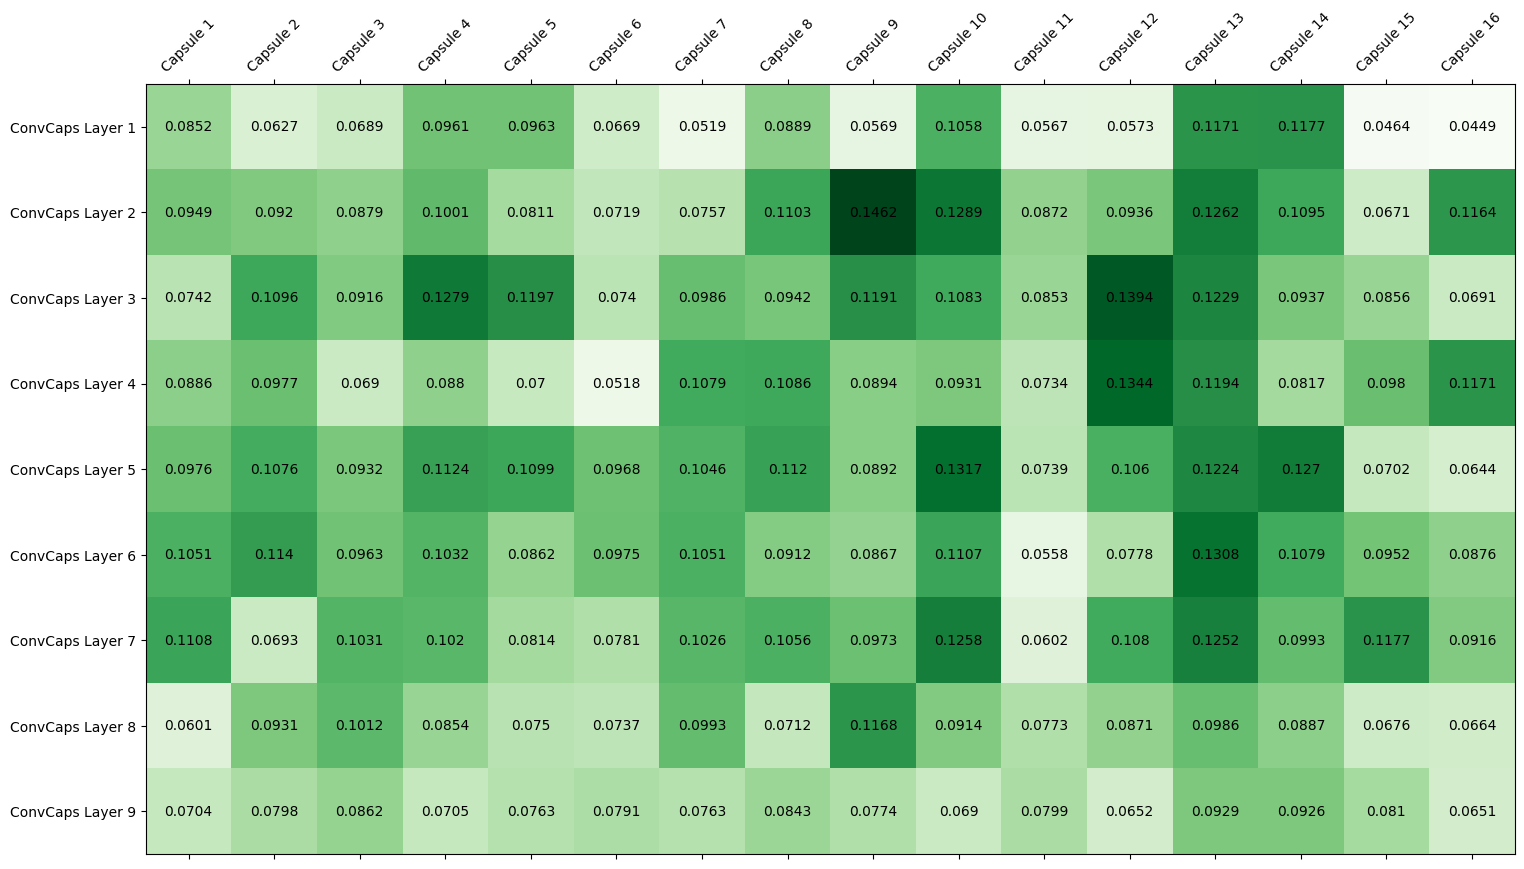

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter9_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter9_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

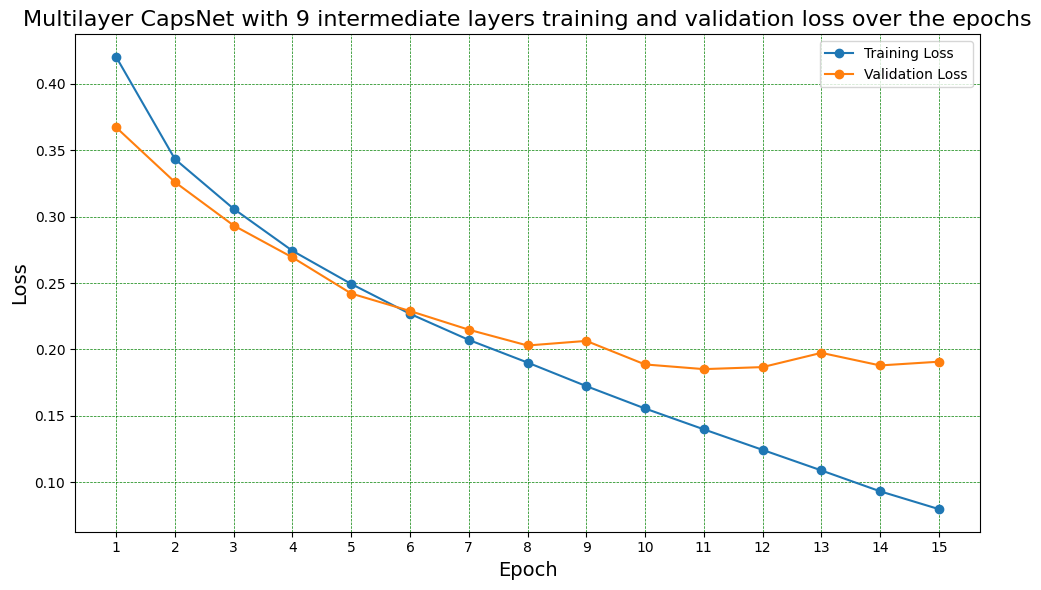

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer CapsNet with 9 intermediate layers training and validation loss over the epochs')

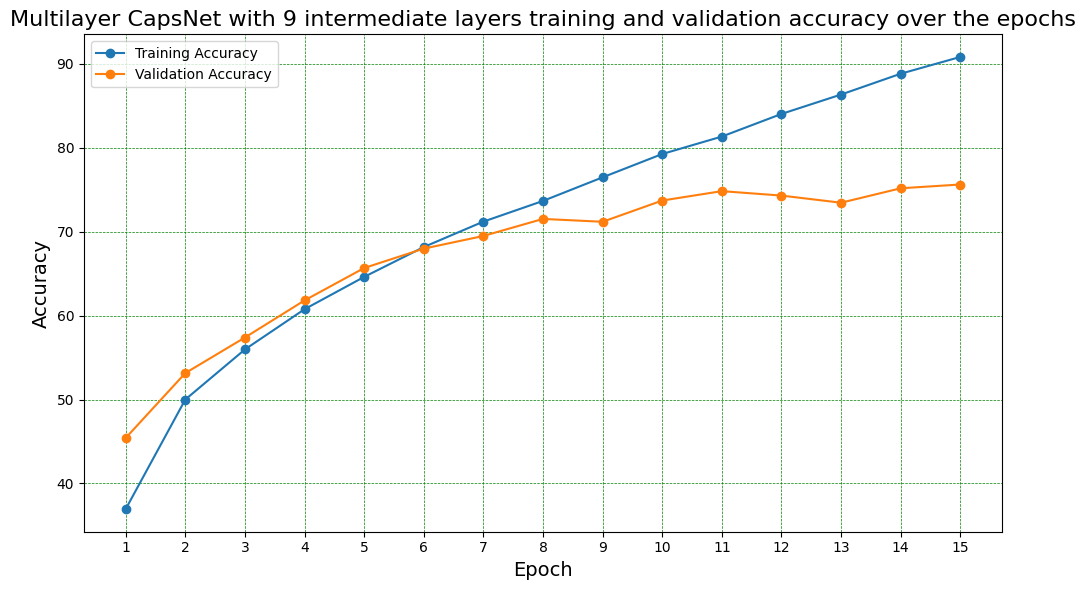

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer CapsNet with 9 intermediate layers training and validation accuracy over the epochs')

In [ ]:
from google.colab import runtime
runtime.unassign()

## 10 Intermediate Layered CapsNet

In [9]:
multilayer_inter10_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=10,
                                                              prim_caps_channels=16, prim_caps_dim=12, n_caps_layers=10)

multilayer_inter10_capsnet_cifar10_model.name = 'multilayer_inter10_capsnet_cifar10_model'
multilayer_inter10_capsnet_cifar10_model = multilayer_inter10_capsnet_cifar10_model.to(device)
multilayer_inter10_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [10]:
%%time
n_epochs = 15
batch_size = 32
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=10)

best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
                                                                multilayer_inter10_capsnet_cifar10_model,
                                                                criterion,
                                                                train_loader,
                                                                test_loader,
                                                                CIFAR10_TRAIN_DIR,
                                                                logger,
                                                                device=device)

Files already downloaded and verified
Files already downloaded and verified


03/02 07:52:33 PM | multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7621, Top 1 Acc=15.62, Top 5 Acc=46.88
INFO:capsnet:multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7621, Top 1 Acc=15.62, Top 5 Acc=46.88
03/02 07:52:48 PM | multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6072, Top 1 Acc=14.49, Top 5 Acc=57.95
INFO:capsnet:multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6072, Top 1 Acc=14.49, Top 5 Acc=57.95
03/02 07:53:04 PM | multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5803, Top 1 Acc=17.64, Top 5 Acc=60.87
INFO:capsnet:multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5803, Top 1 Acc=17.64, Top 5 Acc=60.87
03/02 07:53:19 PM | multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0.5608, Top 1 Acc=19.52, Top

CPU times: user 3h 7min 46s, sys: 11min, total: 3h 18min 46s
Wall time: 3h 18min 17s


Checkpoint restart

In [ ]:
# %%time
# n_epochs = 30
# batch_size = 32
# CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"

# train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

# criterion = caps.CapsNetLoss(n_class=10)

# checkpoint_file = CIFAR10_TRAIN_DIR+'Trained_multilayer_inter10_capsnet_cifar10_model_Epoch15_of_15.pt'

# best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
#                                                                 multilayer_inter10_capsnet_cifar10_model,
#                                                                 criterion,
#                                                                 train_loader,
#                                                                 test_loader,
#                                                                 CIFAR10_TRAIN_DIR,
#                                                                 logger,
#                                                                 device=device,
#                                                                 checkpoint_file=checkpoint_file)

100%|██████████| 170498071/170498071 [00:01<00:00, 91333369.93it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


01/22 12:54:20 AM | multilayer_inter10_capsnet_cifar10_model Training - Epoch=16, Iteration=(0/1563), Loss=0.1371, Top 1 Acc=84.38, Top 5 Acc=96.88
INFO:capsnet:multilayer_inter10_capsnet_cifar10_model Training - Epoch=16, Iteration=(0/1563), Loss=0.1371, Top 1 Acc=84.38, Top 5 Acc=96.88
01/22 12:54:35 AM | multilayer_inter10_capsnet_cifar10_model Training - Epoch=16, Iteration=(32/1563), Loss=0.0948, Top 1 Acc=88.64, Top 5 Acc=98.77
INFO:capsnet:multilayer_inter10_capsnet_cifar10_model Training - Epoch=16, Iteration=(32/1563), Loss=0.0948, Top 1 Acc=88.64, Top 5 Acc=98.77
01/22 12:54:51 AM | multilayer_inter10_capsnet_cifar10_model Training - Epoch=16, Iteration=(64/1563), Loss=0.1013, Top 1 Acc=87.50, Top 5 Acc=99.04
INFO:capsnet:multilayer_inter10_capsnet_cifar10_model Training - Epoch=16, Iteration=(64/1563), Loss=0.1013, Top 1 Acc=87.50, Top 5 Acc=99.04
01/22 12:55:06 AM | multilayer_inter10_capsnet_cifar10_model Training - Epoch=16, Iteration=(96/1563), Loss=0.1000, Top 1 Acc=87.

CPU times: user 3h 6min 23s, sys: 10min 42s, total: 3h 17min 6s
Wall time: 3h 16min 43s


### Export ConvCaps Activation

In [10]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"
batch_size=32
n_epochs=15
n_class=10

n_caps_layers=10
prim_caps_channels=16
prim_caps_dim=12

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
trained_multilayer_inter10_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter10_capsnet_cifar10_model.pt')

best_multilayer_inter10_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                    model_conv_config=model_conv_config,
                                                                    prim_caps_channels=prim_caps_channels,
                                                                    prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter10_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter10_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter10_capsnet_cifar10_model.name = 'best_multilayer_inter10_capsnet_cifar10_model'
best_multilayer_inter10_capsnet_cifar10_model = best_multilayer_inter10_capsnet_cifar10_model.to(device)
best_multilayer_inter10_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [13]:
capsnet_inter10_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter10_capsnet_cifar10_model,
                                                                          test_loader, logger, CIFAR10_TRAIN_DIR, device)

03/02 11:11:23 PM | best_multilayer_inter10_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=90.625, Top 5 Acc=100.000
INFO:capsnet:best_multilayer_inter10_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=90.625, Top 5 Acc=100.000
03/02 11:11:23 PM | best_multilayer_inter10_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=76.562, Top 5 Acc=96.875
INFO:capsnet:best_multilayer_inter10_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=76.562, Top 5 Acc=96.875
03/02 11:11:24 PM | best_multilayer_inter10_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=79.167, Top 5 Acc=97.917
INFO:capsnet:best_multilayer_inter10_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=79.167, Top 5 Acc=97.917
03/02 11:11:24 PM | best_multilayer_inter10_capsnet_cifar10_model - Iterations=4/313, Batch Size=32, Top 1 Acc=83.594, Top 5 Acc=98.438
INFO:capsnet:best_multilayer_inter10_capsnet_cifar10_model - Iterat

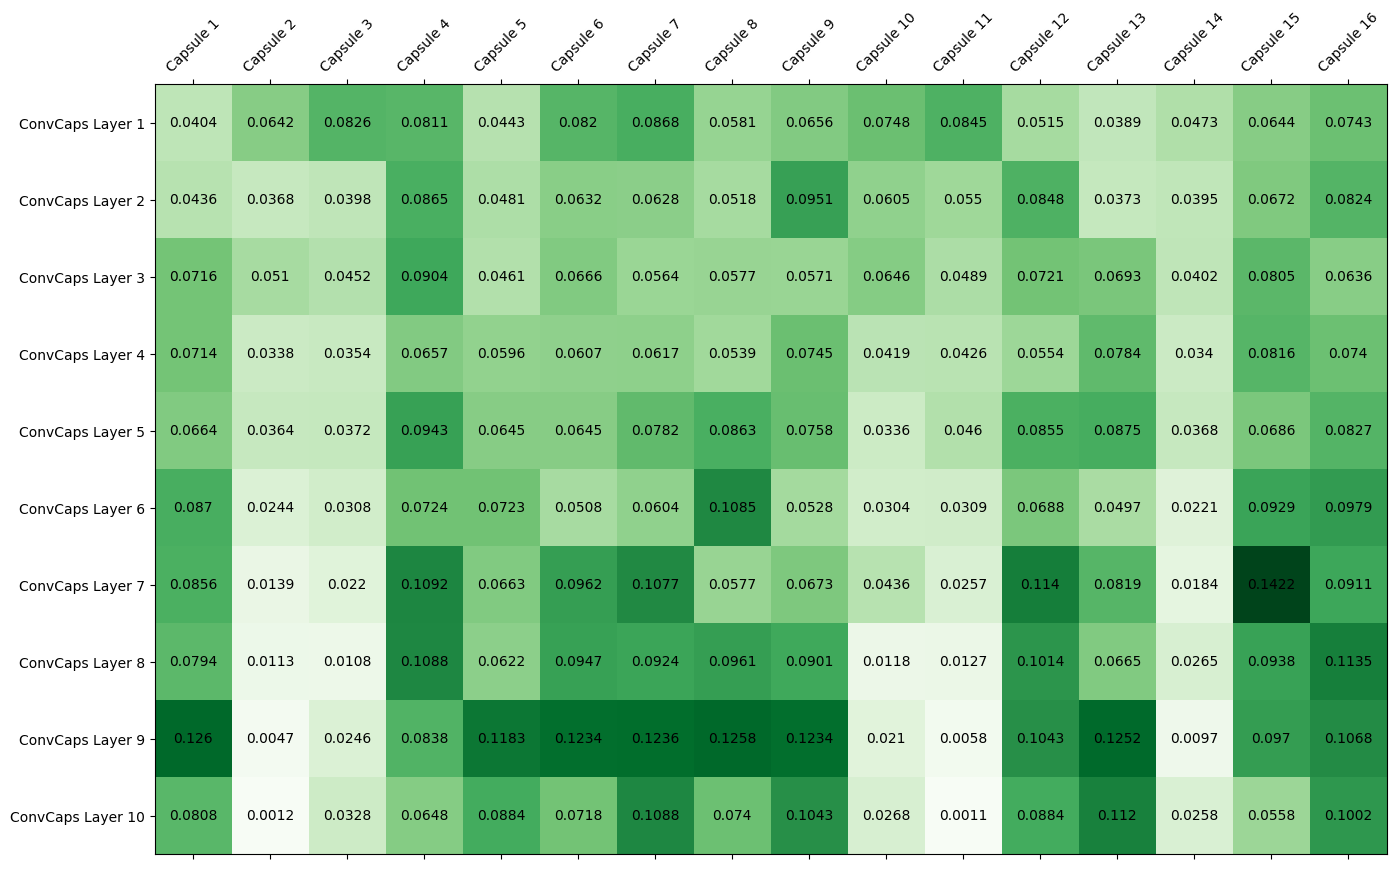

In [14]:
utils.plot_caps_layers_activations(capsnet_inter10_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

ConvCaps Activation for Epoch 1

In [16]:
trained_inter10_capsnet_model_epoch1 = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter10_capsnet_cifar10_model_Epoch1_of_15.pt')

multilayer_inter10_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                               model_conv_config=model_conv_config,
                                                               prim_caps_channels=prim_caps_channels,
                                                               prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter10_capsnet_cifar10_model.load_state_dict(trained_inter10_capsnet_model_epoch1['model_state_dict'])

multilayer_inter10_capsnet_cifar10_model.name = 'trained_multilayer_inter10_capsnet_cifar10_model_epoch1'
multilayer_inter10_capsnet_cifar10_model = multilayer_inter10_capsnet_cifar10_model.to(device)
multilayer_inter10_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [17]:
epoch1_convcaps_activations = utils.extract_convcaps_activations(multilayer_inter10_capsnet_cifar10_model,
                                                                  test_loader, logger, CIFAR10_TRAIN_DIR, device)

03/02 11:12:34 PM | trained_multilayer_inter10_capsnet_cifar10_model_epoch1 - Iterations=1/313, Batch Size=32, Top 1 Acc=71.875, Top 5 Acc=100.000
INFO:capsnet:trained_multilayer_inter10_capsnet_cifar10_model_epoch1 - Iterations=1/313, Batch Size=32, Top 1 Acc=71.875, Top 5 Acc=100.000
03/02 11:12:35 PM | trained_multilayer_inter10_capsnet_cifar10_model_epoch1 - Iterations=2/313, Batch Size=32, Top 1 Acc=62.500, Top 5 Acc=92.188
INFO:capsnet:trained_multilayer_inter10_capsnet_cifar10_model_epoch1 - Iterations=2/313, Batch Size=32, Top 1 Acc=62.500, Top 5 Acc=92.188
03/02 11:12:35 PM | trained_multilayer_inter10_capsnet_cifar10_model_epoch1 - Iterations=3/313, Batch Size=32, Top 1 Acc=64.583, Top 5 Acc=94.792
INFO:capsnet:trained_multilayer_inter10_capsnet_cifar10_model_epoch1 - Iterations=3/313, Batch Size=32, Top 1 Acc=64.583, Top 5 Acc=94.792
03/02 11:12:35 PM | trained_multilayer_inter10_capsnet_cifar10_model_epoch1 - Iterations=4/313, Batch Size=32, Top 1 Acc=59.375, Top 5 Acc=95.3

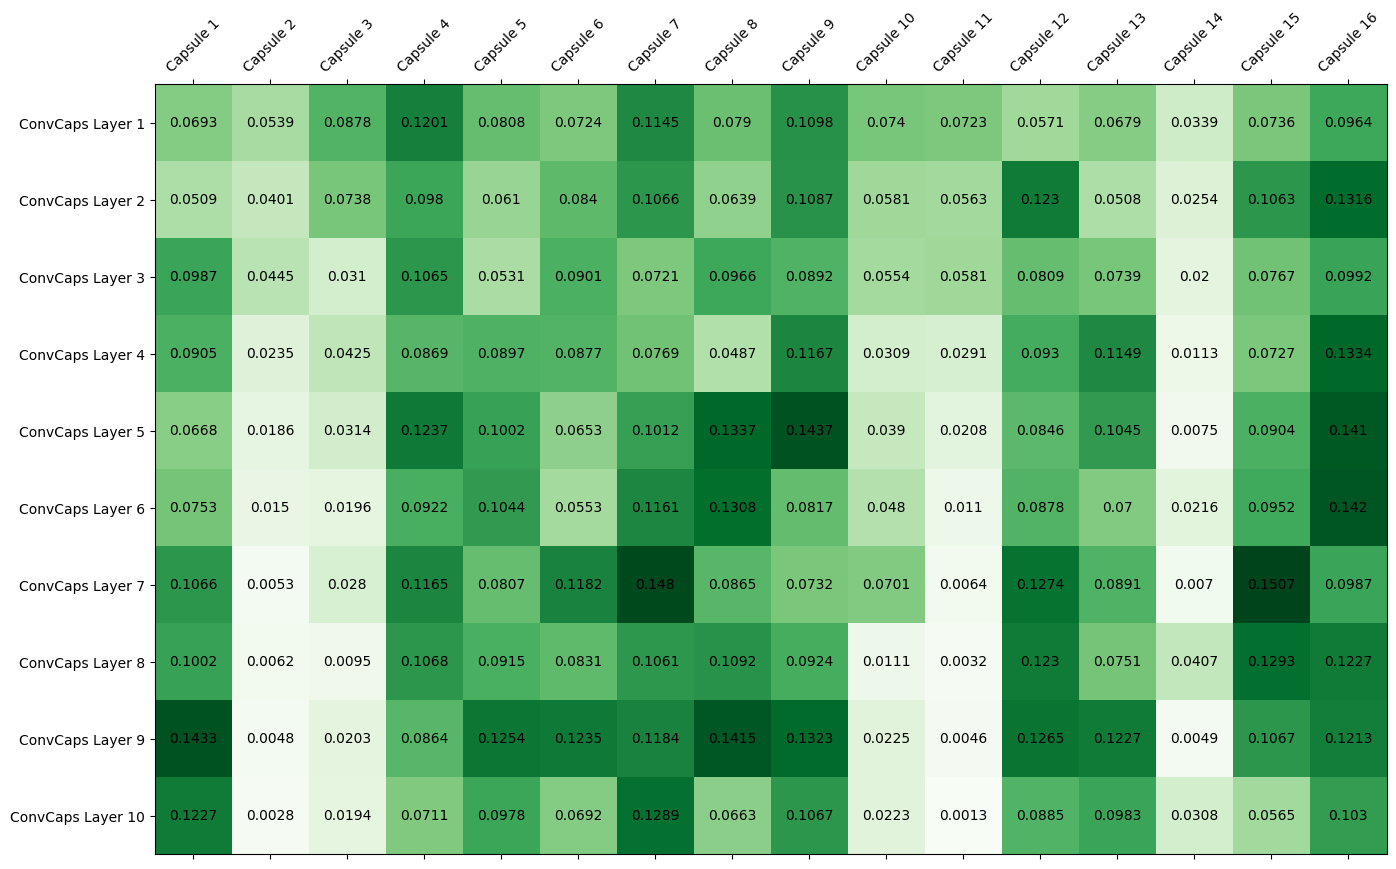

In [18]:
utils.plot_caps_layers_activations(epoch1_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

ConvCaps Activation for Epoch 15

In [11]:
trained_inter10_capsnet_model_epoch30 = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter10_capsnet_cifar10_model_Epoch15_of_15.pt')

multilayer_inter10_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                    model_conv_config=model_conv_config,
                                                                    prim_caps_channels=prim_caps_channels,
                                                                    prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter10_capsnet_cifar10_model.load_state_dict(trained_inter10_capsnet_model_epoch30['model_state_dict'])

multilayer_inter10_capsnet_cifar10_model.name = 'trained_multilayer_inter10_capsnet_cifar10_model_epoch15'
multilayer_inter10_capsnet_cifar10_model = multilayer_inter10_capsnet_cifar10_model.to(device)
multilayer_inter10_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [14]:
epoch15_convcaps_activations = utils.extract_convcaps_activations(multilayer_inter10_capsnet_cifar10_model,
                                                                  test_loader, logger, CIFAR10_TRAIN_DIR, device)

03/02 11:24:40 PM | trained_multilayer_inter10_capsnet_cifar10_model_epoch15 - Iterations=1/313, Batch Size=32, Top 1 Acc=93.750, Top 5 Acc=100.000
INFO:capsnet:trained_multilayer_inter10_capsnet_cifar10_model_epoch15 - Iterations=1/313, Batch Size=32, Top 1 Acc=93.750, Top 5 Acc=100.000
03/02 11:24:41 PM | trained_multilayer_inter10_capsnet_cifar10_model_epoch15 - Iterations=2/313, Batch Size=32, Top 1 Acc=75.000, Top 5 Acc=93.750
INFO:capsnet:trained_multilayer_inter10_capsnet_cifar10_model_epoch15 - Iterations=2/313, Batch Size=32, Top 1 Acc=75.000, Top 5 Acc=93.750
03/02 11:24:41 PM | trained_multilayer_inter10_capsnet_cifar10_model_epoch15 - Iterations=3/313, Batch Size=32, Top 1 Acc=82.292, Top 5 Acc=95.833
INFO:capsnet:trained_multilayer_inter10_capsnet_cifar10_model_epoch15 - Iterations=3/313, Batch Size=32, Top 1 Acc=82.292, Top 5 Acc=95.833
03/02 11:24:41 PM | trained_multilayer_inter10_capsnet_cifar10_model_epoch15 - Iterations=4/313, Batch Size=32, Top 1 Acc=85.156, Top 5 A

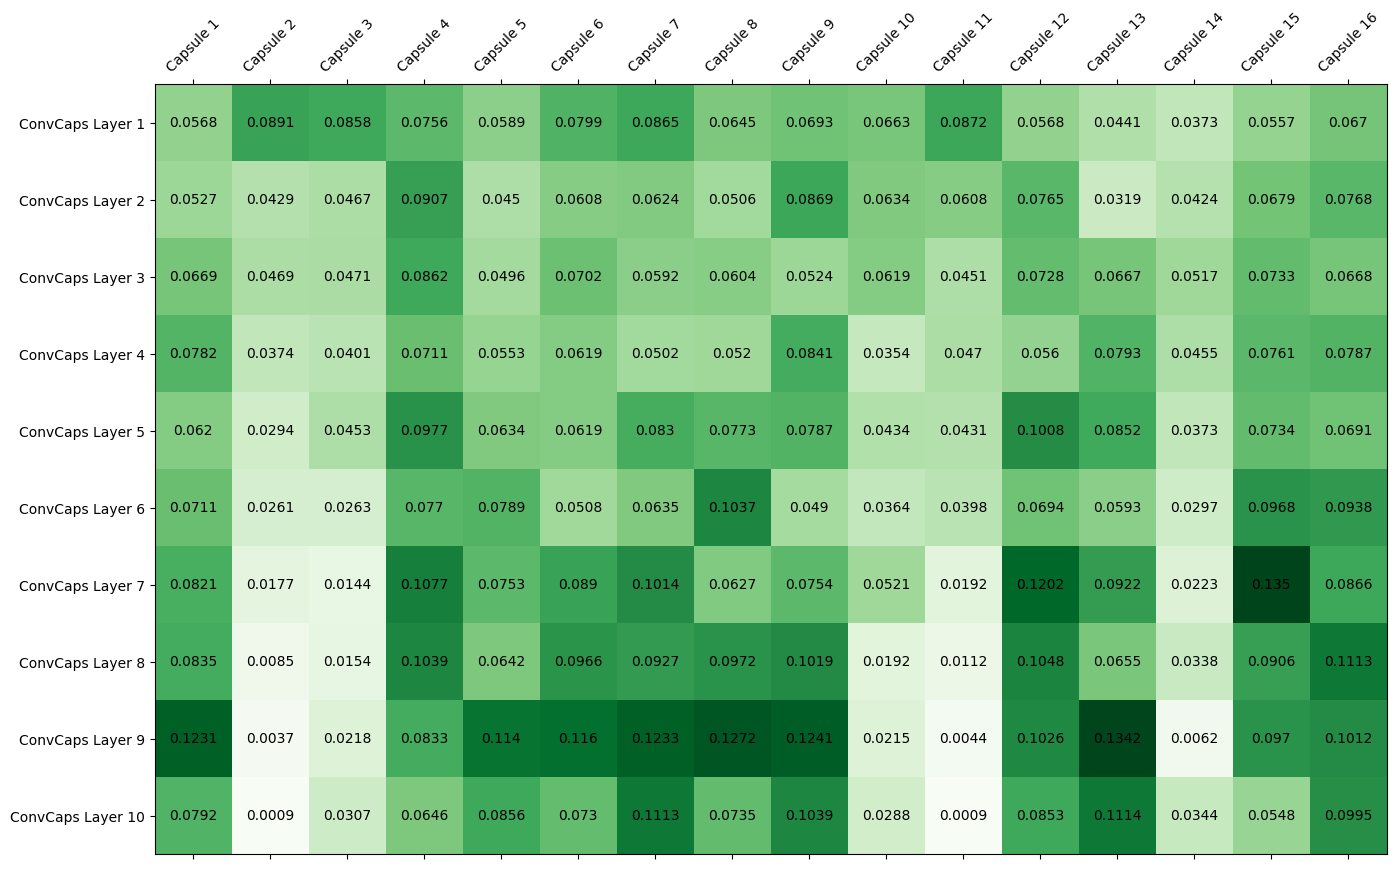

In [15]:
utils.plot_caps_layers_activations(epoch15_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

In [ ]:
# from google.colab import runtime
# runtime.unassign()

### Plots for losses and accuracies

In [22]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter10_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

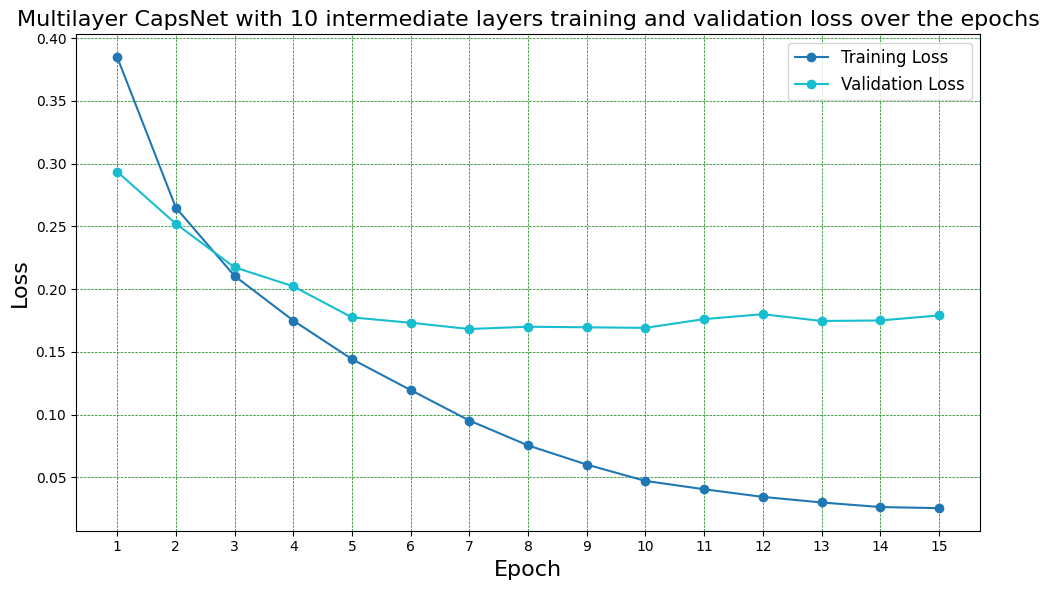

In [23]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer CapsNet with 10 intermediate layers training and validation loss over the epochs')

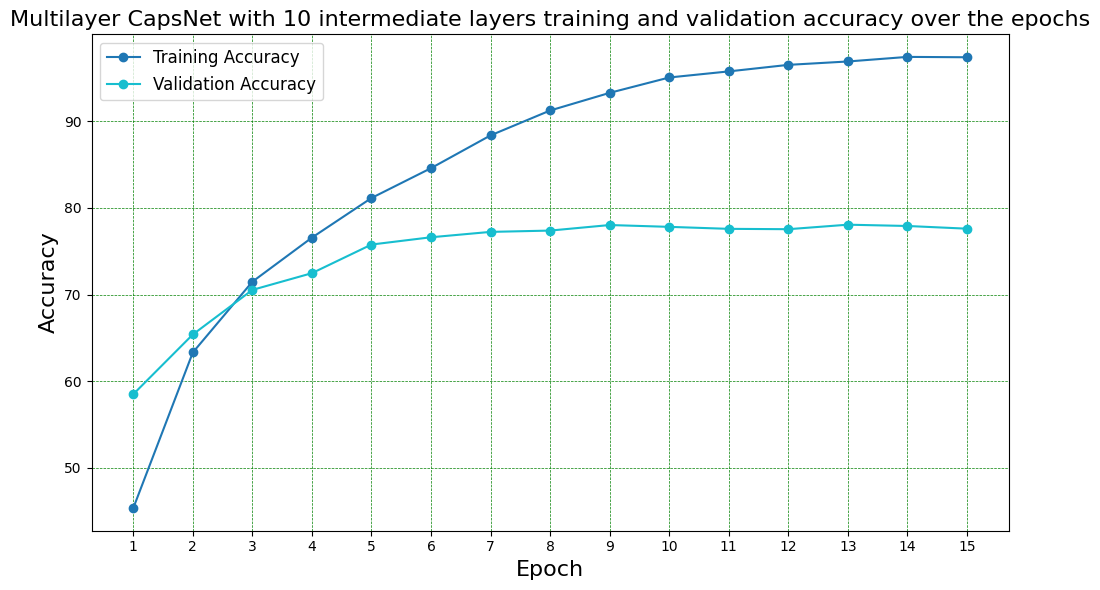

In [24]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer CapsNet with 10 intermediate layers training and validation accuracy over the epochs')

## Plots for Base and All Multilayer CapsNet

In [25]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"

base_capsnet_cifar10_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_base_capsnet_cifar10_model_Epoch30_of_30.pt')
multilayer_capsnet_inter1_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter1_capsnet_cifar10_model_Epoch30_of_30.pt')
multilayer_capsnet_inter2_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter2_capsnet_cifar10_model_Epoch15_of_30.pt')
multilayer_capsnet_inter3_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter3_capsnet_cifar10_model_Epoch15_of_15.pt')
multilayer_capsnet_inter4_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter4_capsnet_cifar10_model_Epoch15_of_15.pt')
multilayer_capsnet_inter5_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter5_capsnet_cifar10_model_Epoch30_of_30.pt')
multilayer_capsnet_inter6_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter6_capsnet_cifar10_model_Epoch15_of_15.pt')
multilayer_capsnet_inter7_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter7_capsnet_cifar10_model_Epoch15_of_15.pt')
multilayer_capsnet_inter8_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter8_capsnet_cifar10_model_Epoch15_of_15.pt')
multilayer_capsnet_inter9_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter9_capsnet_cifar10_model_Epoch15_of_15.pt')
multilayer_capsnet_inter10_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter10_capsnet_cifar10_model_Epoch15_of_15.pt')

In [26]:
models = [base_capsnet_cifar10_model_data,
          multilayer_capsnet_inter1_model_data,
          multilayer_capsnet_inter2_model_data,
          multilayer_capsnet_inter3_model_data,
          multilayer_capsnet_inter4_model_data,
          multilayer_capsnet_inter5_model_data,
          multilayer_capsnet_inter6_model_data,
          multilayer_capsnet_inter7_model_data,
          multilayer_capsnet_inter8_model_data,
          multilayer_capsnet_inter9_model_data,
          multilayer_capsnet_inter10_model_data]

legends = ['Base',
           '1 InterLayer',
           '2 InterLayers',
           '3 InterLayers',
           '4 InterLayers',
           '5 InterLayers',
           '6 InterLayers',
           '7 InterLayers',
           '8 InterLayers',
           '9 InterLayers',
           '10 InterLayers']

n_epochs = 15

epoch_losses = np.zeros((len(models), n_epochs))
epoch_accuracies = np.zeros((len(models), n_epochs))

for indx, model in enumerate(models):
    epoch_losses[indx] = model['epoch_loss'][:,:15][1]
    epoch_accuracies[indx] = model['epoch_accuracy'][:, :15][1]

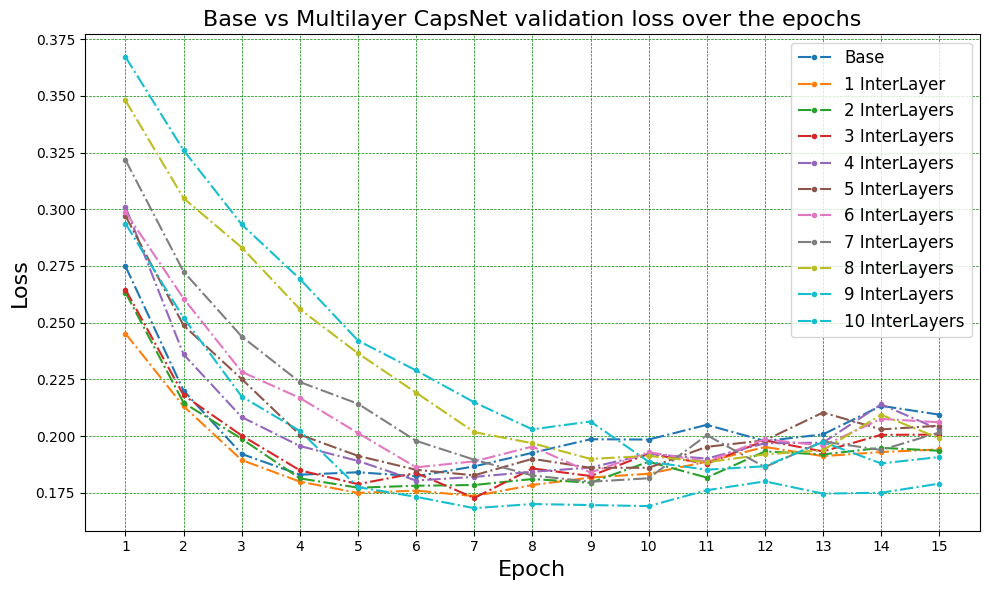

In [29]:
utils.plot_line_chart(epoch_losses, legends, 'Epoch', 'Loss',
                      'Base vs Multilayer CapsNet validation loss over the epochs', marker='.', line='-.')

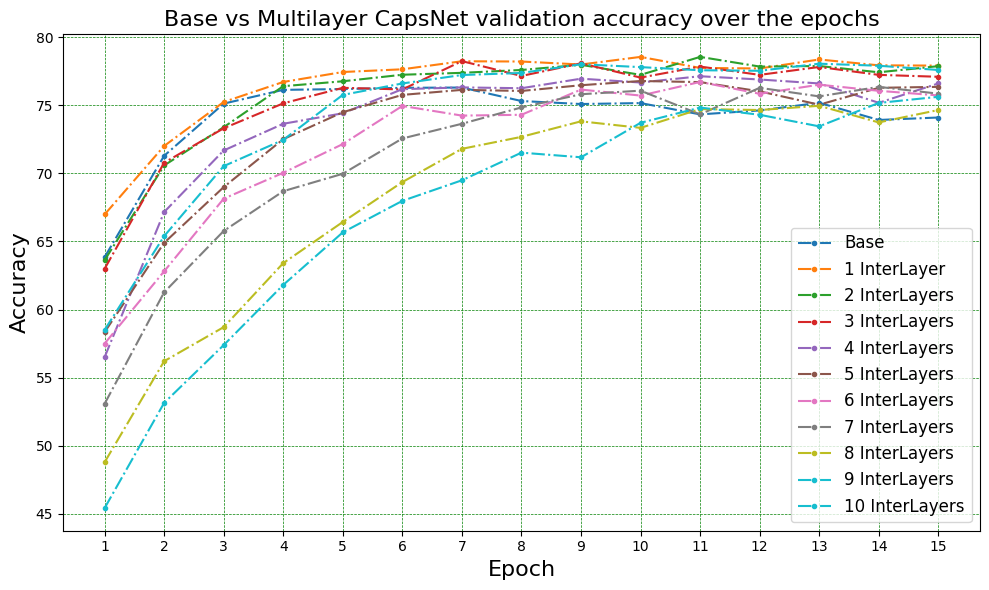

In [30]:
utils.plot_line_chart(epoch_accuracies, legends, 'Epoch', 'Accuracy',
                      'Base vs Multilayer CapsNet validation accuracy over the epochs', marker='.', line='-.')